# Traffic Analysis using Deep Learning (LSTM)

**Group**: G3  
**Project**: Traffic Analysis for Howest Campus (CTAI)  
**Team**: Hadi, Rares, Hamzzah  
**Date**: January 2026

---

## Overview
This notebook analyzes traffic patterns around Howest Campus using **LSTM (Long Short-Term Memory)** neural networks to predict traffic volumes across different transportation modes (car, bike, pedestrian, heavy vehicles) and evaluate the impact of parking scenarios on traffic flow.

This deep learning approach differs from the Random Forest model by:
- **Capturing temporal sequences**: Using past hours to predict future traffic
- **Learning complex patterns**: Neural networks can model non-linear relationships
- **Handling time dependencies**: LSTM cells remember long-term patterns in traffic data

## Import Libraries

We'll use TensorFlow/Keras for deep learning, along with pandas, numpy, sklearn, and visualization libraries.

In [1]:
# UPDATED: Added seed setting for full reproducibility
import os
import random

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility (after imports)
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ GPU Available: {len(tf.config.list_physical_devices('GPU'))} device(s)")
print(f"✓ Random seed set to: {RANDOM_SEED}")

2026-01-15 13:13:32.095257: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 13:13:32.134182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 13:13:33.000355: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✓ TensorFlow version: 2.20.0
✓ GPU Available: 1 device(s)
✓ Random seed set to: 42


## Data Loading and Preprocessing

Loading the merged traffic and weather data, following the same preprocessing steps as the Random Forest notebook.

In [2]:
# Load the merged traffic and weather data
df = pd.read_csv("data/traffic_weather_merged.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2467, 33)


instance_id  segment_id                       date interval    uptime  \
0           -1  9000008372  2025-11-21 09:00:00+01:00   hourly  0.499722   
1           -1  9000008372  2025-11-21 10:00:00+01:00   hourly  0.999444   
2           -1  9000008372  2025-11-21 11:00:00+01:00   hourly  0.999167   
3           -1  9000008372  2025-11-21 12:00:00+01:00   hourly  0.999722   
4           -1  9000008372  2025-11-21 13:00:00+01:00   hourly  0.999167   

   heavy   car  bike  pedestrian  night  ...      timezone   v85  \
0    0.0  34.0   4.0         4.0    0.0  ...  Europe/Paris  27.5   
1    0.0  39.0  11.0         6.0    0.0  ...  Europe/Paris  25.5   
2    2.0  31.0  16.0         6.0    0.0  ...  Europe/Paris  29.5   
3    1.0  47.0  30.0        20.0    0.0  ...  Europe/Paris  32.5   
4    1.0  26.0  19.0        36.0    0.0  ...  Europe/Paris  35.5   

            street_name  temperature_c  precipitation_mm  rain_mm  \
0  Sintmartenslatemlaan            0.2               0.0      0.0   
1  Sintmartenslatemlaan            0.8               0.0      0.0   
2  Sintmartenslatemlaan            1.3               0.0      0.0   
3  Sintmartenslatemlaan            2.4               0.0      0.0   
4  Sintmartenslatemlaan            2.6               0.0      0.0   

   snowfall_cm  cloud_cover_pct  wind_speed_kmh  sunshine_duration_s  
0          0.0              100            12.2                 6.59  
1          0.0              100            13.4              3600.00  
2          0.0              100            11.0               672.91  
3          0.0               98             9.6              3600.00  
4          0.0              100             9.2              3600.00  

[5 rows x 33 columns]

In [3]:
# Convert date string to datetime and extract temporal features
df["datetime"] = pd.to_datetime(df["date"])
df["date_only"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Monday, 6=Sunday
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

print("Temporal features created:")
df[["datetime", "hour", "dayofweek", "is_weekend"]].head()

Temporal features created:


datetime  hour  dayofweek  is_weekend
0 2025-11-21 09:00:00+01:00     9          4           0
1 2025-11-21 10:00:00+01:00    10          4           0
2 2025-11-21 11:00:00+01:00    11          4           0
3 2025-11-21 12:00:00+01:00    12          4           0
4 2025-11-21 13:00:00+01:00    13          4           0

In [4]:
# Load and merge holiday data
holidays = pd.read_csv("data/belgian_holidays.csv")
holidays["date"] = pd.to_datetime(holidays["date"]).dt.date
holidays["is_holiday"] = 1

# Load and merge school vacation data
vac = pd.read_csv("data/school_vacations.csv")
vac["date"] = pd.to_datetime(vac["date"]).dt.date
vac["is_school_vacation"] = 1

# Merge with main dataframe
df = df.merge(holidays[["date", "is_holiday"]],
              left_on="date_only", right_on="date", how="left")
df = df.merge(vac[["date", "is_school_vacation"]],
              left_on="date_only", right_on="date", how="left")

# Fill NaN values with 0 (non-holiday, non-vacation days)
df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)
df["is_school_vacation"] = df["is_school_vacation"].fillna(0).astype(int)

print("Calendar features added:")
df[["datetime", "is_holiday", "is_school_vacation"]].head()

Calendar features added:


datetime  is_holiday  is_school_vacation
0 2025-11-21 09:00:00+01:00           0                   0
1 2025-11-21 10:00:00+01:00           0                   0
2 2025-11-21 11:00:00+01:00           0                   0
3 2025-11-21 12:00:00+01:00           0                   0
4 2025-11-21 13:00:00+01:00           0                   0

In [5]:
# Encode street names as numerical codes for modeling
df["street_code"] = df["street_name"].astype("category").cat.codes

print("Street encoding:")
print(df[["street_name", "street_code"]].drop_duplicates())

Street encoding:
                   street_name  street_code
0         Sintmartenslatemlaan            1
1104  Graaf Karel de Goedelaan            0


In [6]:
# Create total people count across all transportation modes
df["total_people"] = df["car"] + df["bike"] + df["pedestrian"] + df["heavy"]

print(f"Total people statistics:")
print(df["total_people"].describe())

Total people statistics:
count    2467.000000
mean       10.518912
std        22.796481
min         0.000000
25%         0.000000
50%         0.000000
75%         8.000000
max       173.000000
Name: total_people, dtype: float64


In [7]:
# Define feature columns for modeling (same as Random Forest)
feature_cols = [
    "hour", "dayofweek", "is_weekend",
    "is_holiday", "is_school_vacation",
    "temperature_c", "precipitation_mm",
    "cloud_cover_pct", "wind_speed_kmh",
    "street_code",
]

# Define target variables (transport modes)
targets = ["car", "bike", "heavy", "pedestrian", "total_people"]
modes = ["car", "bike", "pedestrian", "heavy"]

# Remove rows with missing features
df_model = df.dropna(subset=feature_cols).copy()

# Sort by datetime for time series modeling
df_model = df_model.sort_values("datetime").reset_index(drop=True)

print(f"Clean dataset shape: {df_model.shape}")
print(f"Date range: {df_model['datetime'].min()} to {df_model['datetime'].max()}")

Clean dataset shape: (2467, 44)
Date range: 2025-11-10 14:00:00+01:00 to 2026-01-06 08:00:00+01:00


## Sequence Generation for LSTM

**Key Difference from Random Forest**: LSTM models require sequential data. We create sliding windows of past hours to predict the next hour.

For example, with `LOOKBACK=24`, we use the past 24 hours of data to predict hour 25.

In [8]:
# Hyperparameter: Number of past hours to use for prediction
LOOKBACK = 24  # Use past 24 hours to predict the next hour

# Rush-hour configuration (configurable for different regions/contexts)
RUSH_HOUR_START = 7   # Morning rush hour starts (included)
RUSH_HOUR_END = 17    # Evening rush hour ends (included)

print(f"LSTM Configuration:")
print(f"  - Lookback window: {LOOKBACK} hours")
print(f"  - Input features: {len(feature_cols)}")
print(f"  - Output targets: {len(targets)}")
print(f"  - Rush hours: {RUSH_HOUR_START:02d}:00 - {RUSH_HOUR_END:02d}:00")

LSTM Configuration:
  - Lookback window: 24 hours
  - Input features: 10
  - Output targets: 5
  - Rush hours: 07:00 - 17:00


In [9]:
def create_sequences(data, features, target, lookback=24):
    """
    Create sequences for LSTM training.
    
    Parameters:
    -----------
    data : DataFrame
        Input dataframe with features and target
    features : list
        List of feature column names
    target : str
        Target column name
    lookback : int
        Number of past timesteps to use
        
    Returns:
    --------
    X : np.array
        Feature sequences of shape (samples, lookback, n_features)
    y : np.array
        Target values of shape (samples,)
    indices : np.array
        Original indices for tracking
    """
    X, y, indices = [], [], []
    
    feature_data = data[features].values
    target_data = data[target].values
    
    for i in range(lookback, len(data)):
        X.append(feature_data[i-lookback:i])  # Past 'lookback' hours
        y.append(target_data[i])              # Current hour target
        indices.append(i)
    
    return np.array(X), np.array(y), np.array(indices)

print("Sequence generation function defined.")

Sequence generation function defined.


In [10]:
# Prepare feature matrix
X_full = df_model[feature_cols].values

# Initialize scalers dictionary (one per target for consistency)
scalers = {}

# We'll store all sequences here
sequences_dict = {}

print("Creating sequences for each transportation mode...\n")

for target in targets:
    print(f"Processing: {target}")
    
    # Create sequences
    X_seq, y_seq, idx_seq = create_sequences(
        df_model, 
        feature_cols, 
        target, 
        lookback=LOOKBACK
    )
    
    # Store in dictionary
    sequences_dict[target] = {
        'X': X_seq,
        'y': y_seq,
        'indices': idx_seq
    }
    
    print(f"  - Sequences shape: X={X_seq.shape}, y={y_seq.shape}")

print(f"\nTotal sequences created: {len(sequences_dict[targets[0]]['X'])}")

Creating sequences for each transportation mode...

Processing: car
  - Sequences shape: X=(2443, 24, 10), y=(2443,)
Processing: bike
  - Sequences shape: X=(2443, 24, 10), y=(2443,)
Processing: heavy


  - Sequences shape: X=(2443, 24, 10), y=(2443,)
Processing: pedestrian
  - Sequences shape: X=(2443, 24, 10), y=(2443,)
Processing: total_people
  - Sequences shape: X=(2443, 24, 10), y=(2443,)

Total sequences created: 2443


In [11]:
# Normalize features using StandardScaler
# We'll fit one scaler on all the data and apply to each sequence

# Flatten all sequences to fit scaler
X_all_flat = sequences_dict[targets[0]]['X'].reshape(-1, len(feature_cols))

# Fit scaler
feature_scaler = StandardScaler()
feature_scaler.fit(X_all_flat)

# Scale sequences for each target
for target in targets:
    X_seq = sequences_dict[target]['X']
    
    # Reshape to 2D for scaling
    n_samples, n_timesteps, n_features = X_seq.shape
    X_reshaped = X_seq.reshape(-1, n_features)
    
    # Scale
    X_scaled = feature_scaler.transform(X_reshaped)
    
    # Reshape back to 3D
    X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_features)
    
    # Update in dictionary
    sequences_dict[target]['X_scaled'] = X_scaled

print("Feature scaling completed for all sequences.")

Feature scaling completed for all sequences.


## Model Definition and Training

We'll create separate LSTM models for each transportation mode. Each model:
- Has 2 LSTM layers with dropout for regularization
- Uses early stopping to prevent overfitting
- Saves the best model based on validation loss

In [12]:
def create_lstm_model(lookback, n_features, units1=64, units2=32, dropout=0.2, lr=0.001):
    """
    Create an LSTM model for traffic prediction.
    
    Parameters:
    -----------
    lookback : int
        Number of timesteps in input sequences
    n_features : int
        Number of features per timestep
    units1 : int
        Number of units in first LSTM layer
    units2 : int
        Number of units in second LSTM layer
    dropout : float
        Dropout rate for regularization
    lr : float
        Learning rate for Adam optimizer
        
    Returns:
    --------
    model : Sequential
        Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer - returns sequences for next layer
        LSTM(units1, activation='tanh', return_sequences=True, 
             input_shape=(lookback, n_features)),
        Dropout(dropout),
        
        # Second LSTM layer - returns single vector
        LSTM(units2, activation='tanh', return_sequences=False),
        Dropout(dropout),
        
        # Output layer - single value prediction
        Dense(1, activation='linear')
    ])
    
    # Compile with Adam optimizer and MSE loss
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("LSTM model architecture defined.")

LSTM model architecture defined.


In [13]:
# Create directory for saving models
import os
os.makedirs("Models/DeepLearning_Models", exist_ok=True)

# Dictionary to store trained models and metrics
models = {}
metrics = {}
histories = {}

print("Training LSTM models for each transportation mode...\n")
print("="*70)

for target in targets:
    print(f"\n🚀 Training model for: {target.upper()}")
    print("-"*70)
    
    # Get scaled sequences
    X = sequences_dict[target]['X_scaled']
    y = sequences_dict[target]['y']
    
    # Split into train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False  # Don't shuffle time series!
    )
    
    print(f"  Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Create model
    model = create_lstm_model(
        lookback=LOOKBACK,
        n_features=len(feature_cols),
        units1=64,
        units2=32,
        dropout=0.2,
        lr=0.001
    )
    
    # Callbacks for training
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )
    
    model_checkpoint = ModelCheckpoint(
        f'../Models/saved_models/lstm_{target}.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
    
    # Train model
    print(f"  Training in progress...")
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[early_stop, model_checkpoint],
        verbose=0
    )
    
    # Evaluate on test set
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Store results
    models[target] = model
    metrics[target] = {
        'mae': mae,
        'rmse': rmse,
        'mse': mse
    }
    histories[target] = history.history
    
    print(f"  ✓ Training complete!")
    print(f"  ├─ MAE:  {mae:.3f}")
    print(f"  ├─ RMSE: {rmse:.3f}")
    print(f"  └─ Epochs trained: {len(history.history['loss'])}")

print("\n" + "="*70)
print("✓ All models trained successfully!")
print("="*70)

Training LSTM models for each transportation mode...


🚀 Training model for: CAR
----------------------------------------------------------------------
  Train samples: 1954, Test samples: 489


I0000 00:00:1768479216.483863 1958736 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5560 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


  Training in progress...


2026-01-15 13:13:38.383046: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


  ✓ Training complete!
  ├─ MAE:  3.787
  ├─ RMSE: 7.309
  └─ Epochs trained: 13

🚀 Training model for: BIKE
----------------------------------------------------------------------
  Train samples: 1954, Test samples: 489
  Training in progress...


  ✓ Training complete!
  ├─ MAE:  1.180
  ├─ RMSE: 2.270
  └─ Epochs trained: 11

🚀 Training model for: HEAVY
----------------------------------------------------------------------
  Train samples: 1954, Test samples: 489
  Training in progress...


  ✓ Training complete!
  ├─ MAE:  1.023
  ├─ RMSE: 2.454
  └─ Epochs trained: 17

🚀 Training model for: PEDESTRIAN
----------------------------------------------------------------------
  Train samples: 1954, Test samples: 489
  Training in progress...


  ✓ Training complete!
  ├─ MAE:  2.326
  ├─ RMSE: 6.220
  └─ Epochs trained: 11

🚀 Training model for: TOTAL_PEOPLE
----------------------------------------------------------------------
  Train samples: 1954, Test samples: 489
  Training in progress...


  ✓ Training complete!
  ├─ MAE:  7.040
  ├─ RMSE: 13.568
  └─ Epochs trained: 16

✓ All models trained successfully!


In [14]:
# Display metrics summary table
metrics_df = pd.DataFrame(metrics).T
metrics_df = metrics_df[['mae', 'rmse', 'mse']]
metrics_df.columns = ['MAE', 'RMSE', 'MSE']

print("\n📊 LSTM Model Performance Summary")
print("="*70)
print(metrics_df.round(3))
print("="*70)


📊 LSTM Model Performance Summary
                MAE    RMSE      MSE
car           3.787   7.309   53.415
bike          1.180   2.270    5.154
heavy         1.023   2.454    6.020
pedestrian    2.326   6.220   38.694
total_people  7.040  13.568  184.094


## Model Performance Evaluation

Visualizing how well our LSTM models perform on the test set.

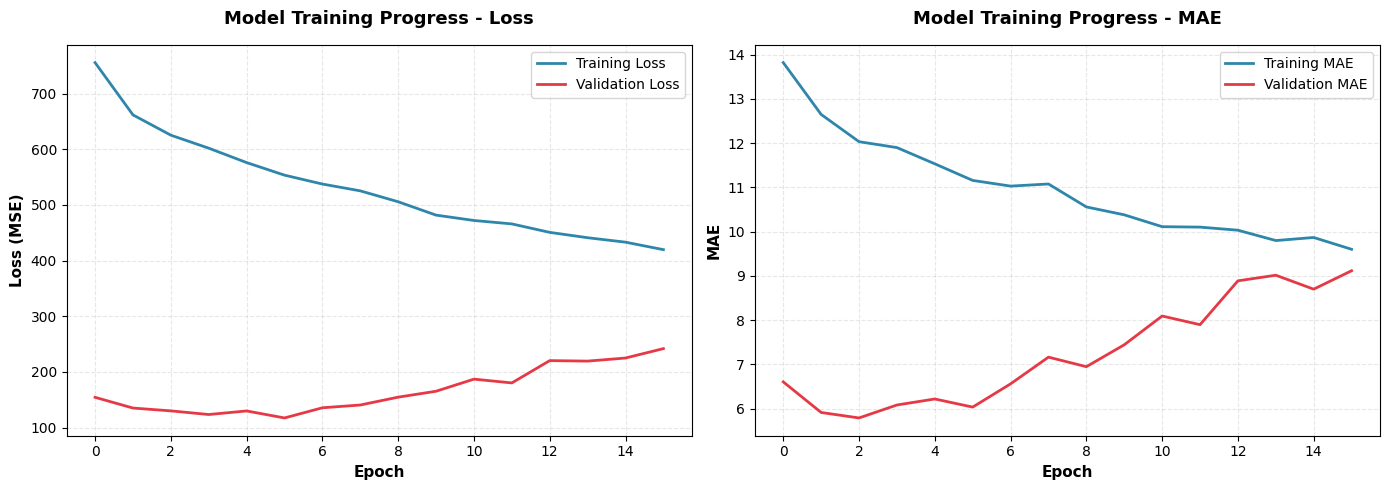

In [15]:
# Training history - loss curves for total_people model
target = 'total_people'
history = histories[target]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2, color='#E63946')
axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Loss (MSE)', fontweight='bold', fontsize=11)
axes[0].set_title('Model Training Progress - Loss', fontweight='bold', fontsize=13, pad=15)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# MAE curve
axes[1].plot(history['mae'], label='Training MAE', linewidth=2, color='#2E86AB')
axes[1].plot(history['val_mae'], label='Validation MAE', linewidth=2, color='#E63946')
axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[1].set_ylabel('MAE', fontweight='bold', fontsize=11)
axes[1].set_title('Model Training Progress - MAE', fontweight='bold', fontsize=13, pad=15)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

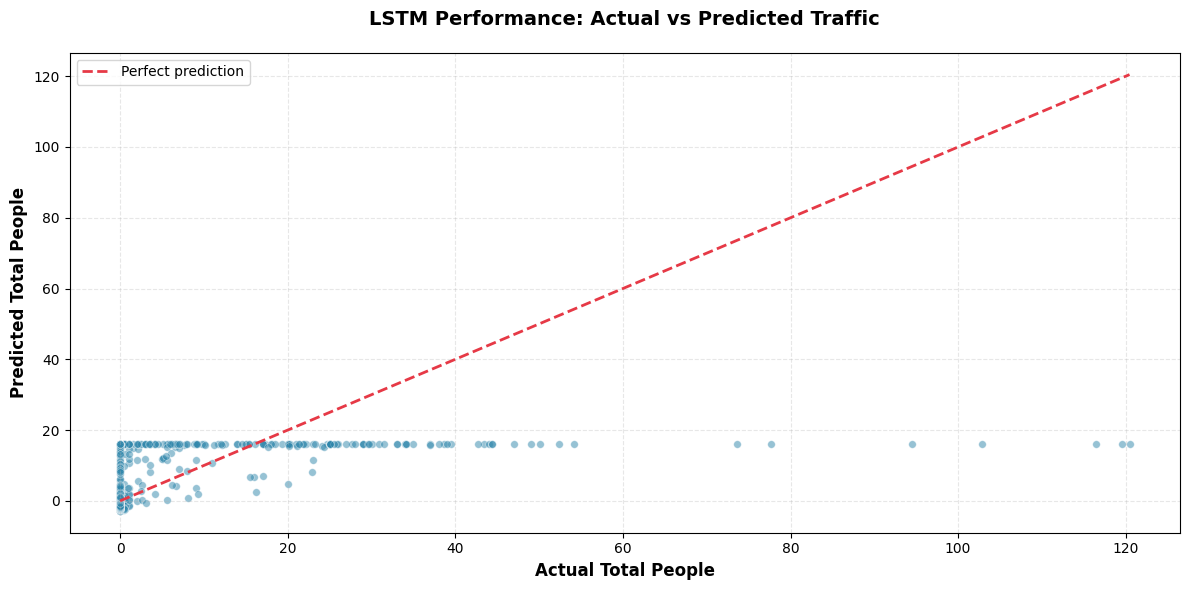

In [16]:
# Actual vs Predicted for total_people
target = 'total_people'
X = sequences_dict[target]['X_scaled']
y = sequences_dict[target]['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

y_pred = models[target].predict(X_test, verbose=0).flatten()

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=30, color='#2E86AB', edgecolors='white', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "--", color='#E63946', linewidth=2, label='Perfect prediction')
plt.xlabel("Actual Total People", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Total People", fontsize=12, fontweight='bold')
plt.title("LSTM Performance: Actual vs Predicted Traffic", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

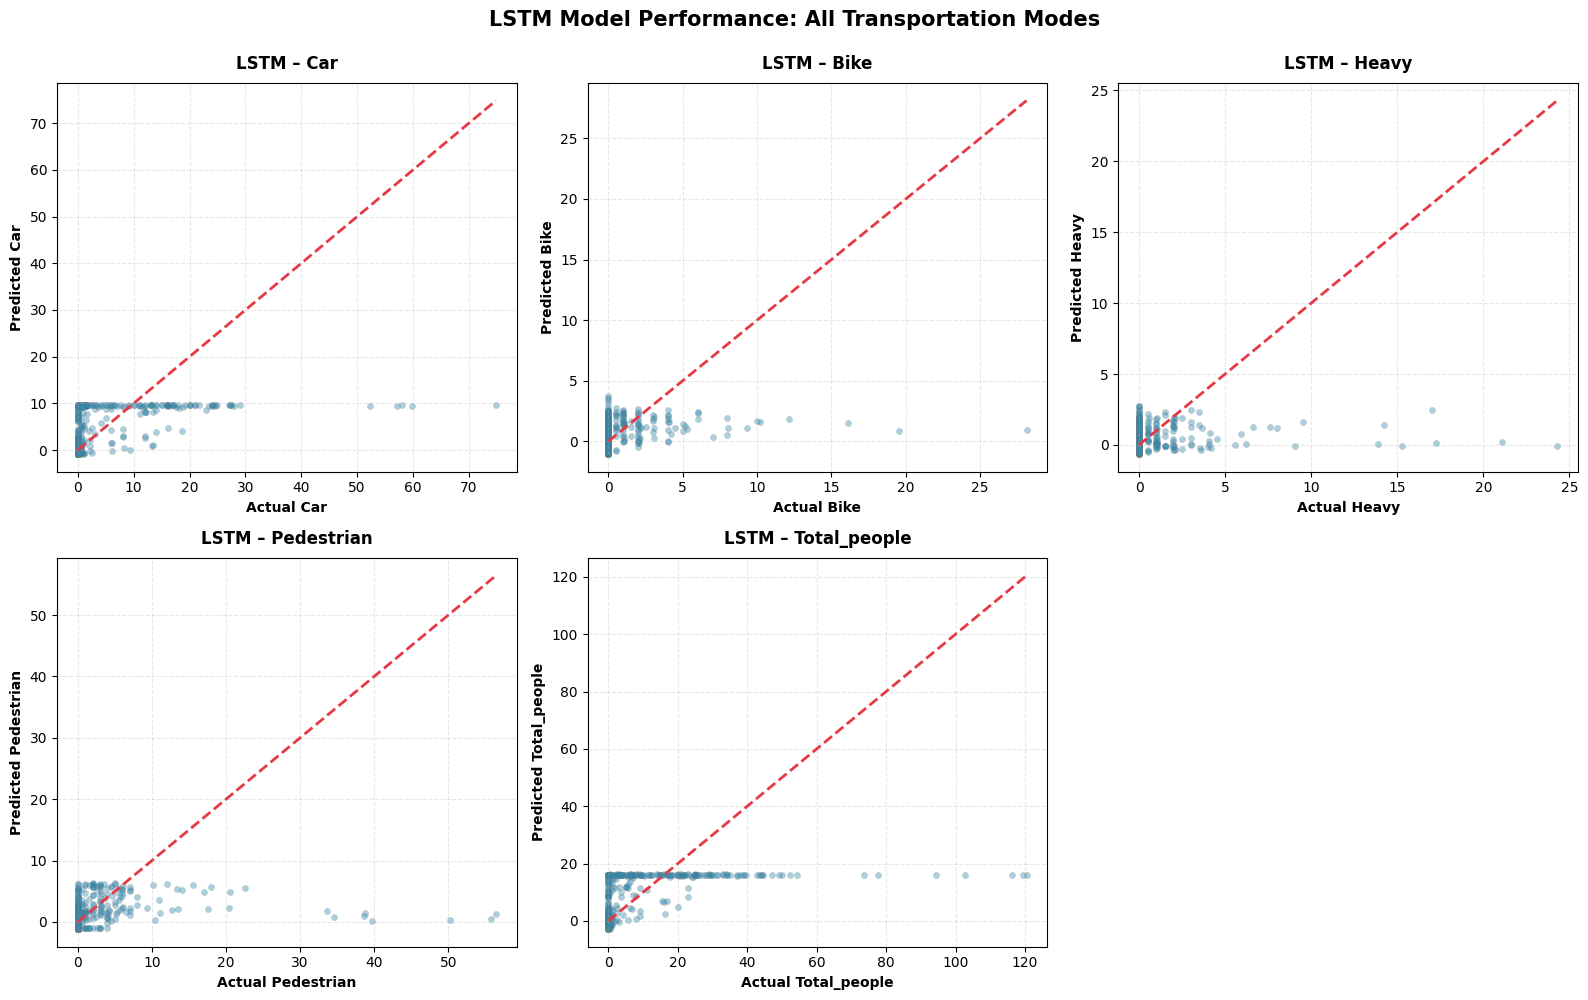

In [17]:
# Actual vs Predicted scatter plots for all targets
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, target in enumerate(targets):
    X = sequences_dict[target]['X_scaled']
    y = sequences_dict[target]['y']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models[target].predict(X_test, verbose=0).flatten()
    
    axes[idx].scatter(y_test, y_pred, alpha=0.4, s=20, color='#2E86AB', edgecolors='gray', linewidth=0.3)
    axes[idx].plot([y_test.min(), y_test.max()],
                   [y_test.min(), y_test.max()], "--", color='#E63946', linewidth=2)
    axes[idx].set_xlabel(f"Actual {target.capitalize()}", fontweight='bold', fontsize=10)
    axes[idx].set_ylabel(f"Predicted {target.capitalize()}", fontweight='bold', fontsize=10)
    axes[idx].set_title(f"LSTM – {target.capitalize()}", fontweight='bold', fontsize=12, pad=10)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

# Hide extra subplot
if len(targets) < len(axes):
    axes[-1].axis('off')

fig.suptitle('LSTM Model Performance: All Transportation Modes', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Actual vs Predicted Over Time

Comparing model predictions against actual traffic patterns over a specific time period.

Generating predictions for 336 hours (2025-12-30 to 2026-01-06)...
✓ Predictions generated



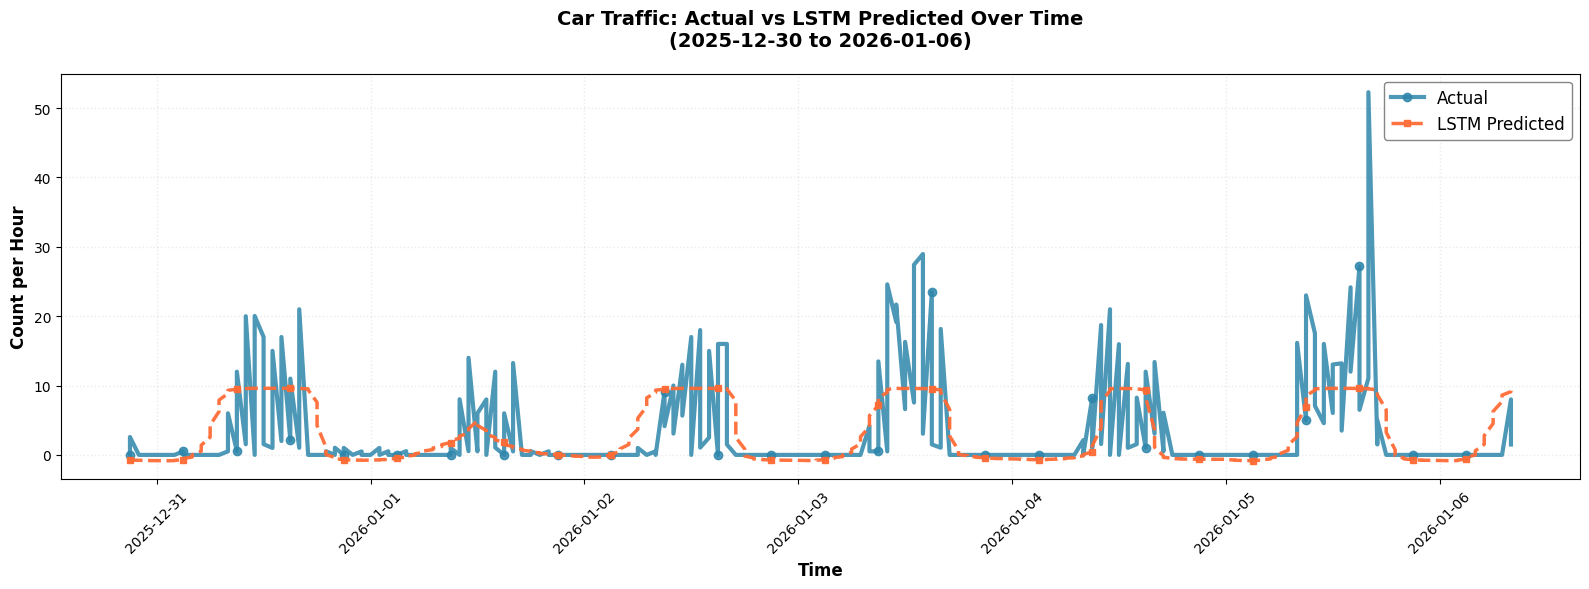

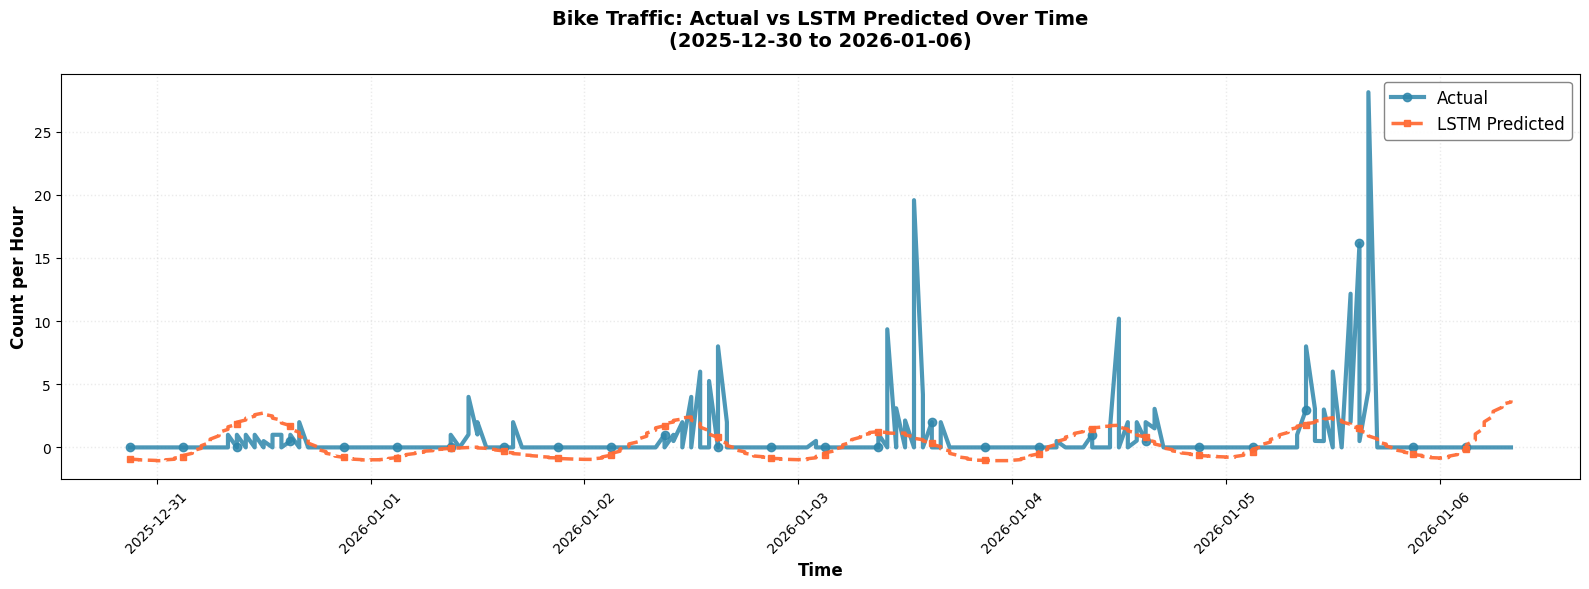

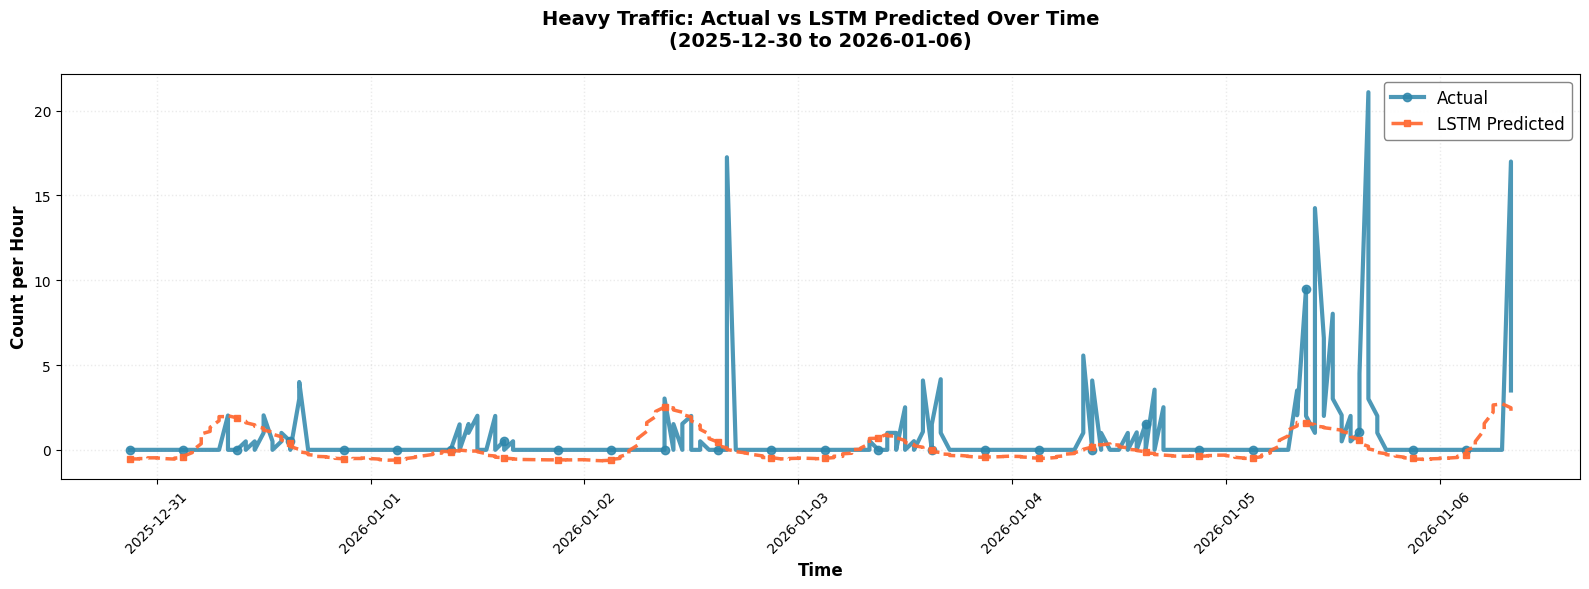

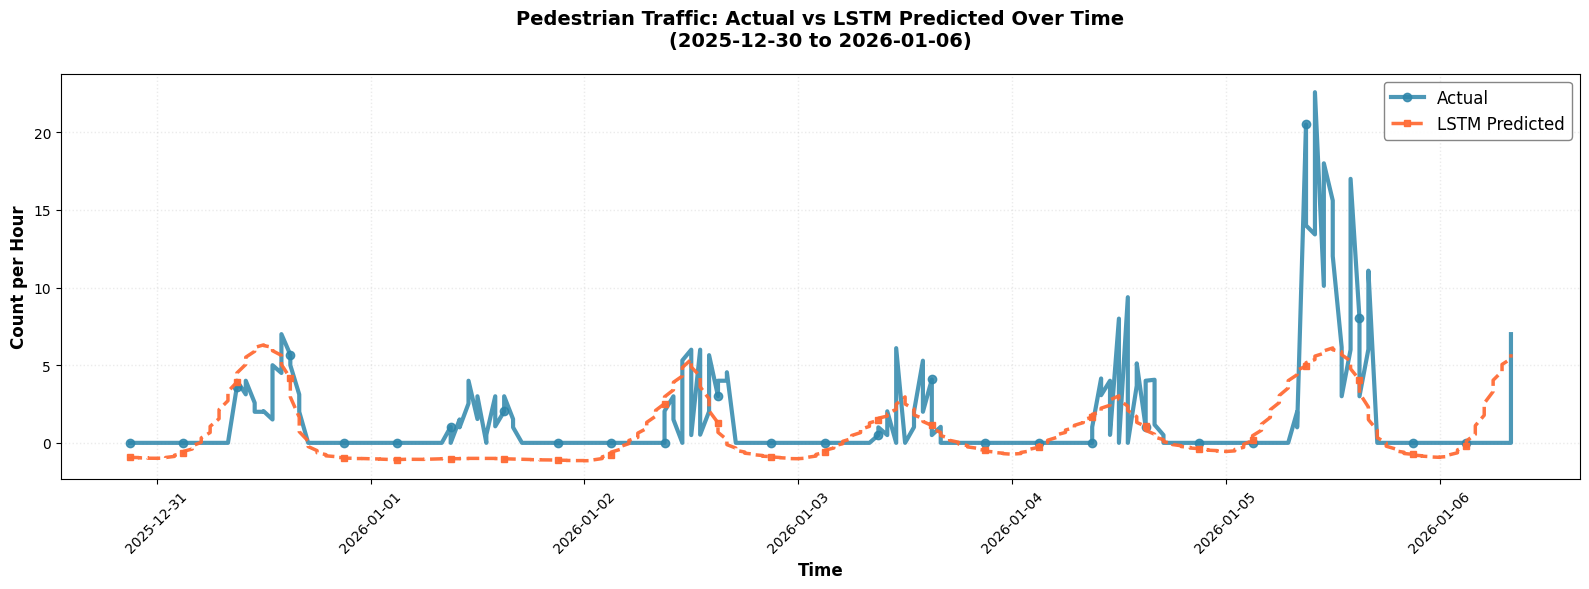

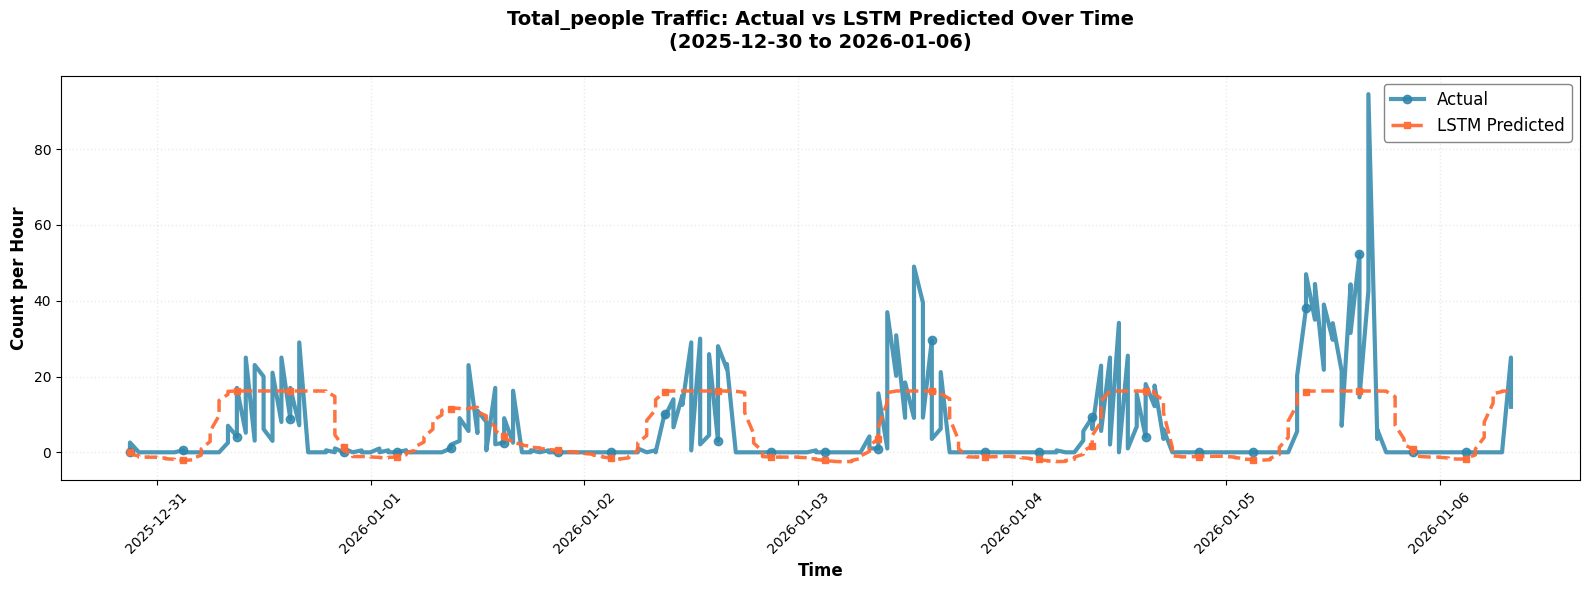

✓ Time-series comparison completed for period: 2025-12-30 to 2026-01-06


In [18]:
# NEW: Actual vs Predicted over time for all transportation modes (OPTIMIZED)
# Select a sample period for visualization - use last 2 weeks of data
sample = df_model.sort_values("datetime")
sample = sample.tail(336).copy()  # Last 336 hours = 2 weeks
start = sample["datetime"].min().strftime("%Y-%m-%d")
end = sample["datetime"].max().strftime("%Y-%m-%d")

print(f"Generating predictions for {len(sample)} hours ({start} to {end})...")

# Generate predictions for the sample period (BATCH OPTIMIZED)
for t in targets:
    # Prepare sequences for this sample
    sample_features = sample[feature_cols].values
    sample_scaled = feature_scaler.transform(sample_features)
    
    # Build all sequences at once for batch prediction
    X_sequences = []
    for i in range(LOOKBACK, len(sample_scaled)):
        X_sequences.append(sample_scaled[i-LOOKBACK:i])
    
    # Batch predict (much faster!)
    if len(X_sequences) > 0:
        X_batch = np.array(X_sequences)
        predictions = models[t].predict(X_batch, verbose=0).flatten()
    else:
        predictions = []
    
    # Add NaN for the first LOOKBACK rows where we can't predict
    sample[f"pred_{t}"] = [np.nan] * LOOKBACK + list(predictions)

print("✓ Predictions generated\n")

# Plot actual vs predicted for each mode
for t in targets:
    plt.figure(figsize=(16, 6))
    
    # Filter out NaN values for plotting
    plot_data = sample[sample[f"pred_{t}"].notna()].copy()
    
    # Plot actual with solid line and circles
    plt.plot(plot_data["datetime"], plot_data[t], label="Actual", 
            linewidth=3, color='#2E86AB', marker='o', markersize=6, 
            markevery=12, alpha=0.85, zorder=2)
    
    # Plot predicted with dashed line and different color
    plt.plot(plot_data["datetime"], plot_data[f"pred_{t}"], label="LSTM Predicted", 
            linewidth=2.5, color='#FF6B35', linestyle='--', marker='s', 
            markersize=5, markevery=12, alpha=0.95, zorder=3)
    
    plt.xlabel("Time", fontsize=12, fontweight='bold')
    plt.ylabel("Count per Hour", fontsize=12, fontweight='bold')
    plt.title(f"{t.capitalize()} Traffic: Actual vs LSTM Predicted Over Time\n({start} to {end})", 
             fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='best', framealpha=0.95, edgecolor='gray', fancybox=True)
    plt.grid(True, alpha=0.25, linestyle=':', linewidth=1)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print(f"✓ Time-series comparison completed for period: {start} to {end}")

## Traffic Pattern Analysis

Analyzing historical patterns in the data to understand traffic behavior.

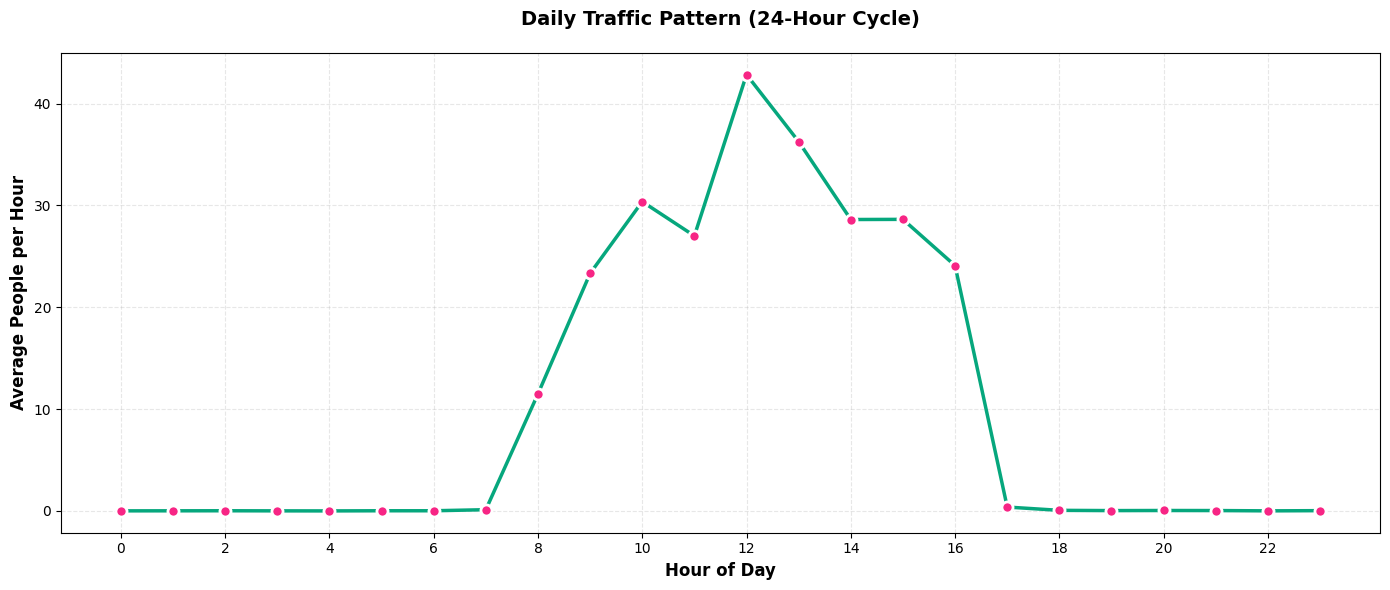

In [19]:
# Hourly traffic pattern
avg_by_hour = df_model.groupby("hour")["total_people"].mean()

plt.figure(figsize=(14, 6))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o", linewidth=2.5, 
        markersize=8, color='#06A77D', markerfacecolor='#F72585', 
        markeredgecolor='white', markeredgewidth=2)
plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.title("Daily Traffic Pattern (24-Hour Cycle)", fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

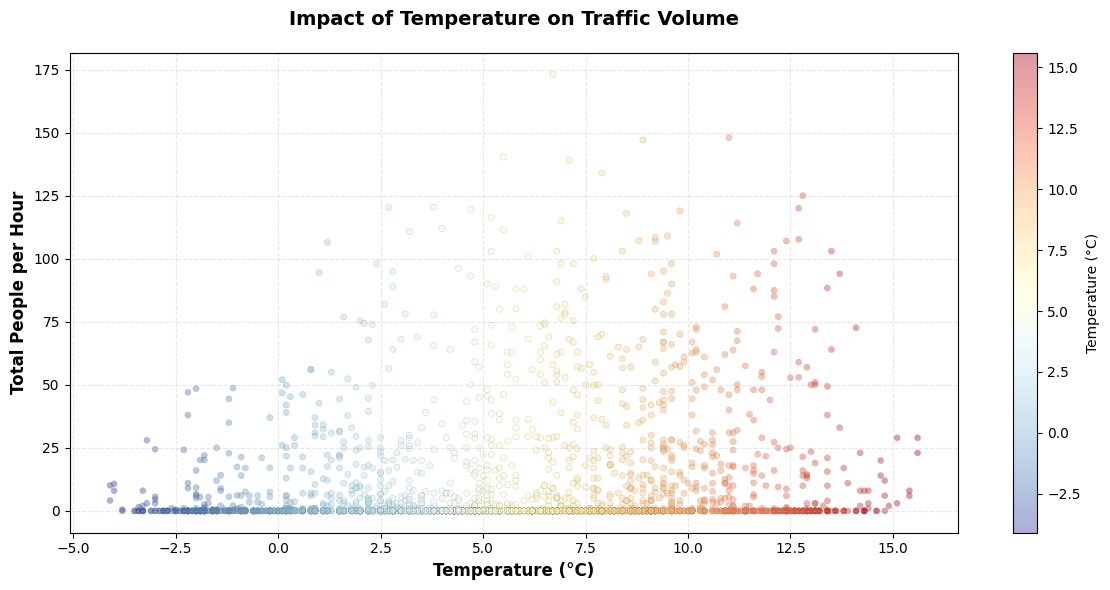

In [20]:
# Temperature impact on traffic
plt.figure(figsize=(12, 6))
plt.scatter(df_model["temperature_c"], df_model["total_people"], 
           alpha=0.4, s=20, c=df_model["temperature_c"], cmap='RdYlBu_r', 
           edgecolors='gray', linewidth=0.3)
cbar = plt.colorbar(label='Temperature (°C)')
plt.xlabel("Temperature (°C)", fontsize=12, fontweight='bold')
plt.ylabel("Total People per Hour", fontsize=12, fontweight='bold')
plt.title("Impact of Temperature on Traffic Volume", fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

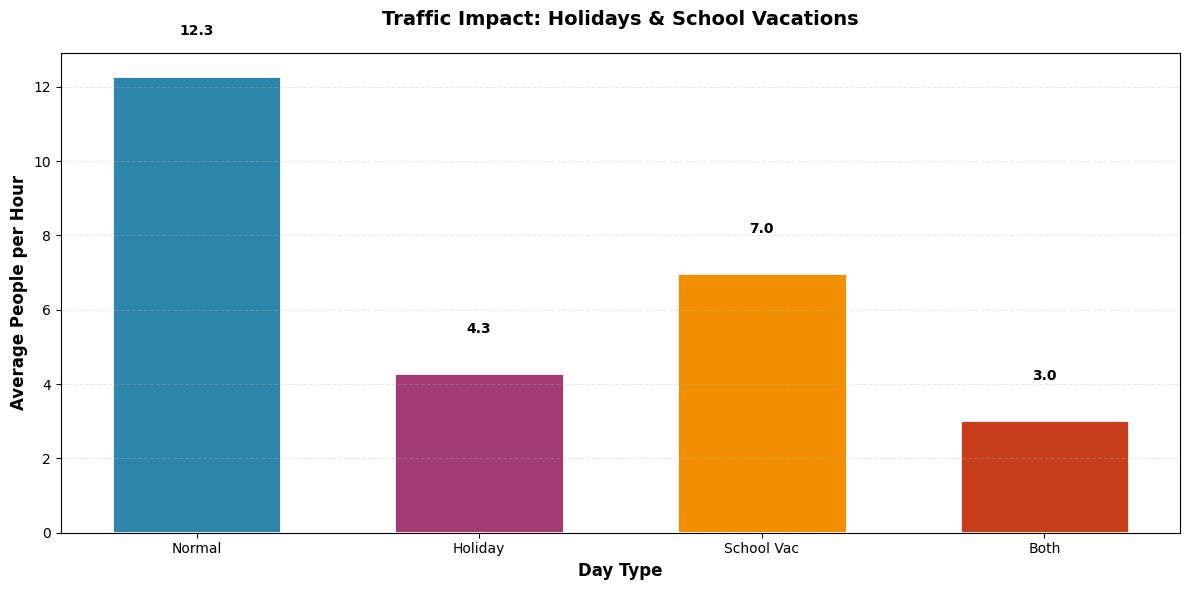

In [21]:
# Holiday and vacation impact
labels = ["Normal", "Holiday", "School Vac", "Both"]
avg_vals = []

for h, v in [(0,0), (1,0), (0,1), (1,1)]:
    avg_vals.append(
        df_model[
            (df_model["is_holiday"] == h) &
            (df_model["is_school_vacation"] == v)
        ]["total_people"].mean()
    )

plt.figure(figsize=(12, 6))
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars = plt.bar(labels, avg_vals, color=colors, edgecolor='white', linewidth=2, width=0.6)

plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.xlabel("Day Type", fontsize=12, fontweight='bold')
plt.title("Traffic Impact: Holidays & School Vacations", fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, v in enumerate(avg_vals):
    plt.text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

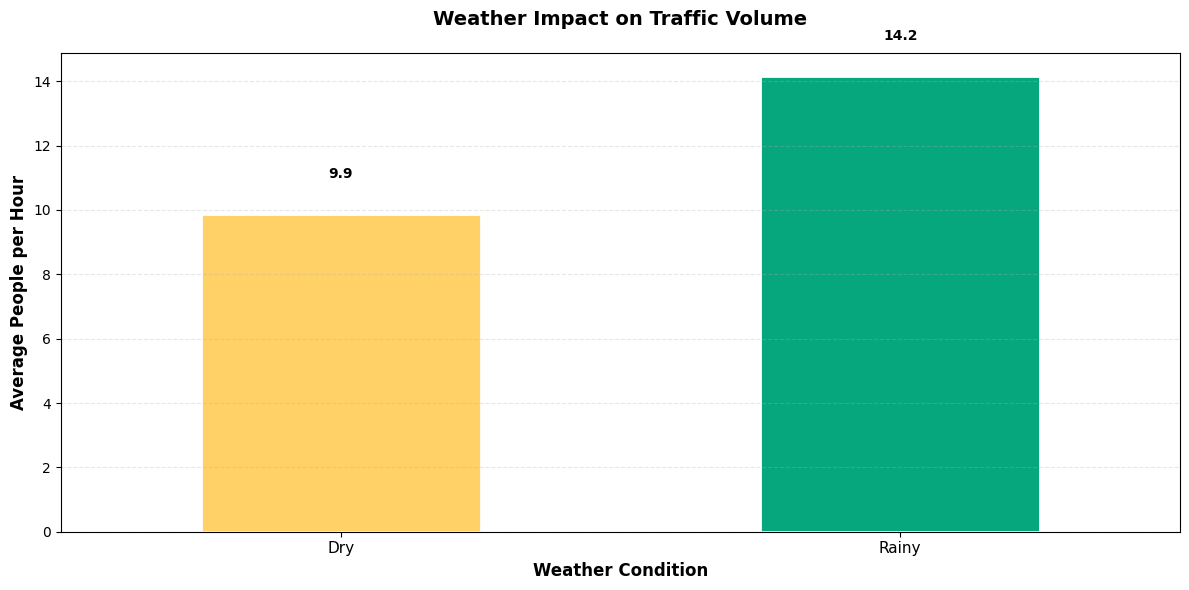

In [22]:
# Rain impact on traffic
df_model["is_rain"] = (df_model["precipitation_mm"] > 0).astype(int)
avg_rain = df_model.groupby("is_rain")["total_people"].mean()

plt.figure(figsize=(12, 6))
colors = ['#FFD166', '#06A77D']
bars = avg_rain.plot(kind="bar", rot=0, color=colors, edgecolor='white', linewidth=2, width=0.5, legend=False)

plt.xticks([0, 1], ["Dry", "Rainy"], fontsize=11)
plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.xlabel("Weather Condition", fontsize=12, fontweight='bold')
plt.title("Weather Impact on Traffic Volume", fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, v in enumerate(avg_rain.values):
    plt.text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

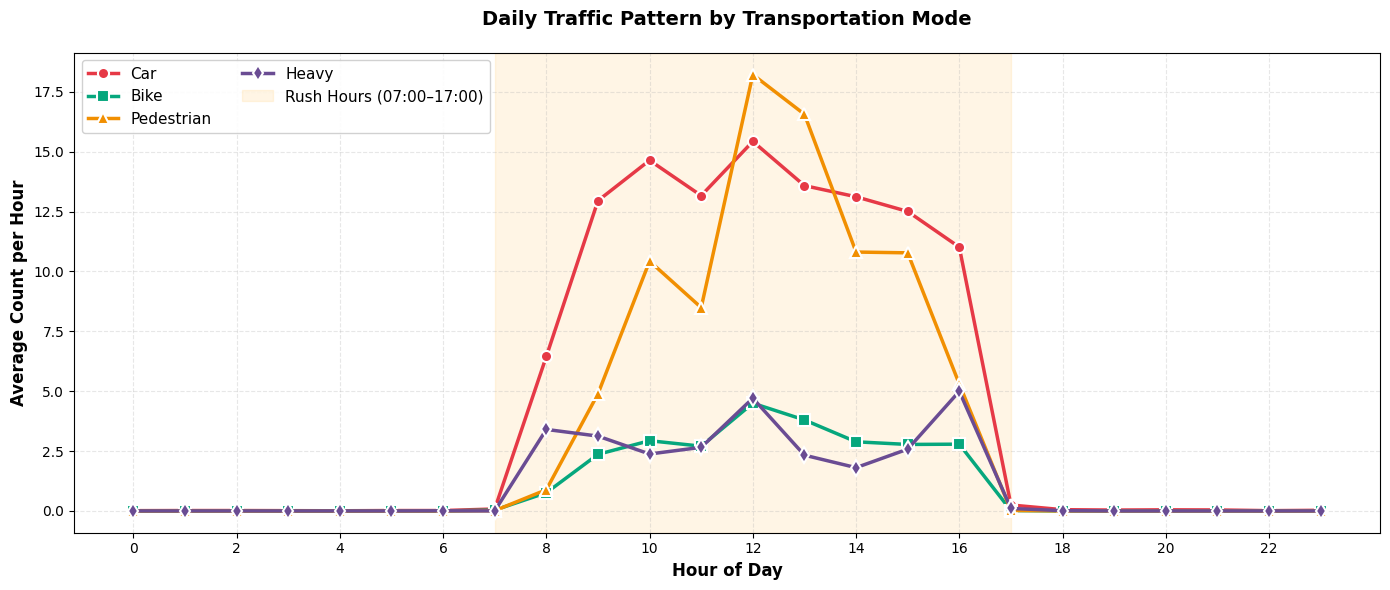

In [23]:
# Traffic by transportation mode - hourly pattern
avg_hour_mode = df_model.groupby("hour")[modes].mean()

plt.figure(figsize=(14, 6))

colors_mode = {'car': '#E63946', 'bike': '#06A77D', 'pedestrian': '#F18F01', 'heavy': '#6A4C93'}
markers_mode = {'car': 'o', 'bike': 's', 'pedestrian': '^', 'heavy': 'd'}

for m in modes:
    plt.plot(avg_hour_mode.index, avg_hour_mode[m],
             marker=markers_mode[m], label=m.capitalize(),
             linewidth=2.5, markersize=8, color=colors_mode[m],
             markeredgecolor='white', markeredgewidth=1.5)

# Shade rush hours
plt.axvspan(RUSH_HOUR_START, RUSH_HOUR_END, alpha=0.1, color='orange', 
           label=f'Rush Hours ({RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00)', zorder=0)

plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Average Count per Hour", fontsize=12, fontweight='bold')
plt.title("Daily Traffic Pattern by Transportation Mode", fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(0, 24, 2))
plt.legend(fontsize=11, loc='upper left', framealpha=0.9, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

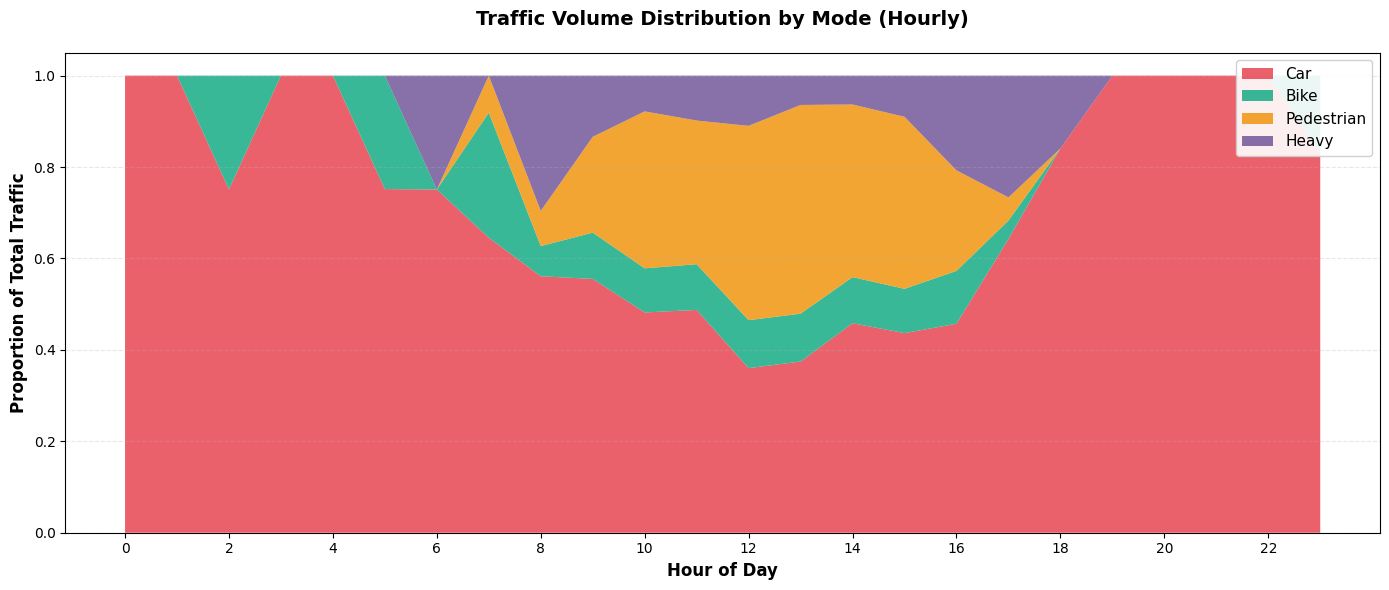

In [24]:
# Mode share over time (stacked area)
share = avg_hour_mode.div(avg_hour_mode.sum(axis=1), axis=0)

plt.figure(figsize=(14, 6))
colors = ['#E63946', '#06A77D', '#F18F01', '#6A4C93']
plt.stackplot(share.index, [share[m] for m in modes],
             labels=[m.capitalize() for m in modes],
             colors=colors, alpha=0.8)

plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Proportion of Total Traffic", fontsize=12, fontweight='bold')
plt.title("Traffic Volume Distribution by Mode (Hourly)", fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="upper right", fontsize=11, framealpha=0.9)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

## Peak Hour Detection & Analysis

Identifying peak traffic hours for each transportation mode and analyzing rush hour patterns.

In [25]:
# NEW: Peak hour detection for each mode
peak_hours_summary = []

for mode in modes:
    hourly_avg = df_model.groupby('hour')[mode].mean()
    peak_hour = hourly_avg.idxmax()
    peak_value = hourly_avg.max()
    min_hour = hourly_avg.idxmin()
    min_value = hourly_avg.min()
    
    peak_hours_summary.append({
        'Mode': mode.capitalize(),
        'Peak Hour': f"{peak_hour}:00",
        'Peak Count': f"{peak_value:.1f}",
        'Minimum Hour': f"{min_hour}:00",
        'Minimum Count': f"{min_value:.1f}",
        'Peak/Min Ratio': f"{peak_value/min_value:.2f}x"
    })

peak_df = pd.DataFrame(peak_hours_summary)

print("\n" + "="*80)
print("PEAK HOUR ANALYSIS BY TRANSPORTATION MODE")
print("="*80)
print(peak_df.to_string(index=False))
print("="*80)
print("\n📊 Insights:")
print(f"   - Rush hours: {RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00 (commuting & work/school activity)")
print("   - Night hours show minimal traffic across all modes")
print("="*80)


PEAK HOUR ANALYSIS BY TRANSPORTATION MODE
      Mode Peak Hour Peak Count Minimum Hour Minimum Count Peak/Min Ratio
       Car     12:00       15.4         4:00           0.0       2900.98x
      Bike     12:00        4.5         0:00           0.0           infx
Pedestrian     12:00       18.2         0:00           0.0           infx
     Heavy     16:00        5.0         0:00           0.0           infx

📊 Insights:
   - Rush hours: 07:00–17:00 (commuting & work/school activity)
   - Night hours show minimal traffic across all modes


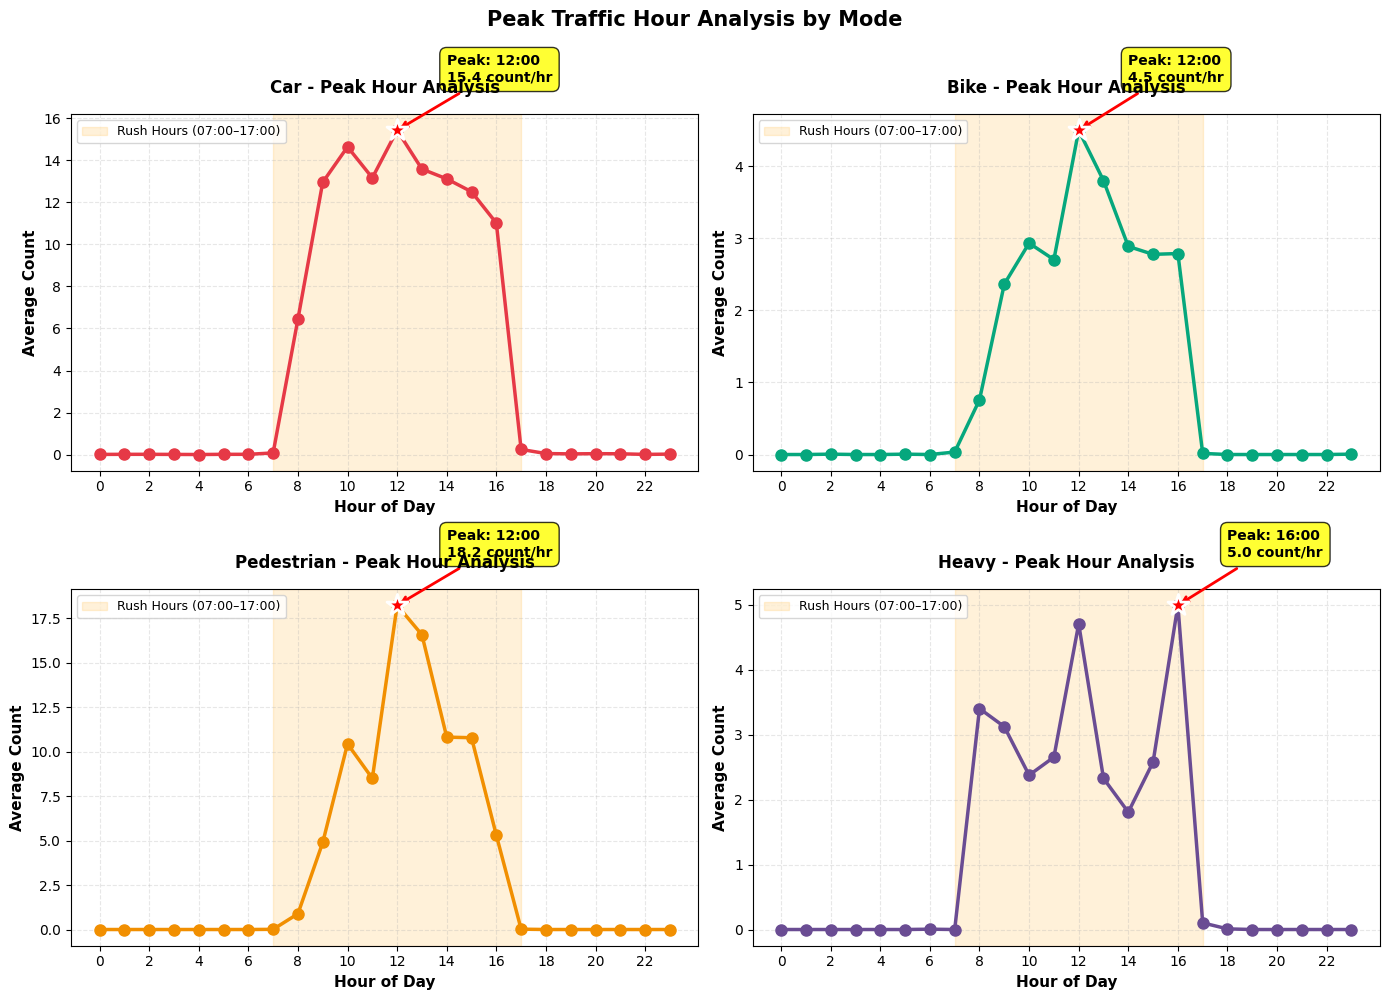

In [26]:
# NEW: Peak hours visualization with annotations
peak_hours = {}
for m in modes:
    hourly_avg = df_model.groupby('hour')[m].mean()
    peak_hours[m] = {'hour': hourly_avg.idxmax(), 'value': hourly_avg.max()}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, m in enumerate(modes):
    hourly_avg = df_model.groupby('hour')[m].mean()
    axes[idx].plot(hourly_avg.index, hourly_avg.values, linewidth=2.5, 
                  color=colors_mode[m], marker='o', markersize=8)
    
    # Highlight peak hour
    peak_h = peak_hours[m]['hour']
    peak_v = peak_hours[m]['value']
    axes[idx].scatter([peak_h], [peak_v], color='red', s=250, zorder=5, 
                     edgecolors='white', linewidth=2, marker='*')
    axes[idx].annotate(f'Peak: {peak_h}:00\n{peak_v:.1f} count/hr', 
                      xy=(peak_h, peak_v), xytext=(peak_h+2, peak_v*1.15),
                      fontsize=10, fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                      arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    axes[idx].set_xlabel('Hour of Day', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Average Count', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'{m.capitalize()} - Peak Hour Analysis', 
                       fontweight='bold', fontsize=12, pad=15)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].set_xticks(range(0, 24, 2))
    
    # Shade rush hours using configured constants
    axes[idx].axvspan(RUSH_HOUR_START, RUSH_HOUR_END, alpha=0.15, color='orange', 
                     label=f'Rush Hours ({RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00)')
    axes[idx].legend(fontsize=9, loc='upper left')

fig.suptitle('Peak Traffic Hour Analysis by Mode', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Future Traffic Prediction (Flexible Horizon)

Using our trained **LSTM models** to predict traffic for a flexible time horizon.

**Flexible Forecast**: The `horizon_days` parameter allows forecasting for 1, 2, 3, 4, 5+ weeks.

**Note**: LSTM requires past data (lookback window) to make predictions, so we use the most recent historical data as the starting point.

In [27]:
def predict_future_lstm(horizon_days=7, street_name='Sintmartenslatemlaan'):
    """
    Generate LSTM predictions for a flexible time horizon.
    
    Parameters:
    -----------
    horizon_days : int
        Number of days to forecast (e.g., 7, 14, 21, 35)
    street_name : str
        Street to predict for ('Sintmartenslatemlaan' or 'Graaf Karel de Goedelaan')
        
    Returns:
    --------
    future_preds : pd.DataFrame
        DataFrame with datetime and predictions for all modes
    """
    horizon_hours = horizon_days * 24
    
    print(f"="*70)
    print(f"FORECAST CONFIGURATION")
    print(f"="*70)
    print(f"Street: {street_name}")
    print(f"Forecast horizon: {horizon_days} days ({horizon_hours} hours)")
    print(f"="*70 + "\n")
    
    # Generate future time range
    last_dt = df_model["datetime"].max()
    
    # Find next Monday for a complete week
    days_until_monday = (7 - last_dt.dayofweek) % 7
    if days_until_monday == 0:
        days_until_monday = 7
    next_monday = last_dt + pd.Timedelta(days=days_until_monday)
    
    # Start from midnight of next Monday
    start_date = next_monday.replace(hour=0, minute=0, second=0, microsecond=0)
    
    # Generate hours based on horizon_days
    future_index = pd.date_range(start=start_date, periods=horizon_hours, freq="H")
    
    future = pd.DataFrame({"datetime": future_index})
    future["date_only"] = future["datetime"].dt.date
    future["hour"] = future["datetime"].dt.hour
    future["dayofweek"] = future["datetime"].dt.dayofweek
    future["is_weekend"] = future["dayofweek"].isin([5, 6]).astype(int)
    
    print(f"Last data timestamp: {last_dt}")
    print(f"Prediction period: {start_date} to {future_index[-1]}")
    
    # Add holiday and vacation data
    future = future.merge(holidays[["date", "is_holiday"]],
                         left_on="date_only", right_on="date", how="left")
    future = future.merge(vac[["date", "is_school_vacation"]],
                         left_on="date_only", right_on="date", how="left")
    
    future["is_holiday"] = future["is_holiday"].fillna(0).astype(int)
    future["is_school_vacation"] = future["is_school_vacation"].fillna(0).astype(int)
    
    # Choose street
    street_code_map = dict(df_model[["street_name","street_code"]].drop_duplicates().values)
    future["street_code"] = street_code_map[street_name]
    
    # Use median weather conditions from historical data
    for col in ["temperature_c","precipitation_mm","cloud_cover_pct","wind_speed_kmh"]:
        future[col] = df_model[col].median()
    
    # Prepare historical data for prediction initialization
    historical_features = df_model[feature_cols].values[-LOOKBACK:]
    historical_scaled = feature_scaler.transform(historical_features)
    
    # Prepare and scale future features
    future_features = future[feature_cols].values
    future_scaled = feature_scaler.transform(future_features)
    
    # Make predictions for all modes
    future_preds = future.copy()
    
    print(f"\nGenerating {horizon_days}-day forecasts with LSTM models...\n")
    
    for target in targets:
        print(f"Predicting: {target}")
        
        model = models[target]
        predictions = predict_future_rolling(
            model, 
            historical_scaled, 
            future_scaled, 
            lookback=LOOKBACK
        )
        
        future_preds[f"pred_{target}"] = predictions
        print(f"  ✓ {len(predictions)} predictions generated")
    
    print("\n✓ All predictions completed!")
    
    return future_preds

print("✓ predict_future_lstm() function defined")

✓ predict_future_lstm() function defined


In [28]:
def predict_future_rolling(model, historical_data, future_features, lookback=24):
    """
    Make multi-step ahead predictions using LSTM with rolling prediction.
    
    Uses rolling prediction: each prediction becomes part of the input for the next step.
    
    Parameters:
    -----------
    model : keras.Model
        Trained LSTM model
    historical_data : np.array
        Recent historical feature data (at least lookback rows)
    future_features : np.array
        Future feature values to use for prediction
    lookback : int
        Number of past timesteps the model expects
        
    Returns:
    --------
    predictions : np.array
        Predicted values for each future timestep
    """
    predictions = []
    
    # Start with the most recent historical data
    current_sequence = historical_data[-lookback:].copy()
    
    # Predict one step at a time
    for i in range(len(future_features)):
        # Reshape for model input: (1, lookback, n_features)
        X_input = current_sequence.reshape(1, lookback, -1)
        
        # Make prediction
        y_pred = model.predict(X_input, verbose=0)[0, 0]
        predictions.append(y_pred)
        
        # Update sequence: remove oldest, add newest (future features)
        current_sequence = np.vstack([current_sequence[1:], future_features[i]])
    
    return np.array(predictions)

print("✓ Rolling prediction helper function defined.")

✓ Rolling prediction helper function defined.


In [29]:
# Generate predictions using the flexible forecast function
future_preds = predict_future_lstm(horizon_days=21, street_name='Sintmartenslatemlaan')

FORECAST CONFIGURATION
Street: Sintmartenslatemlaan
Forecast horizon: 21 days (504 hours)

Last data timestamp: 2026-01-06 08:00:00+01:00
Prediction period: 2026-01-12 00:00:00+01:00 to 2026-02-01 23:00:00+01:00

Generating 21-day forecasts with LSTM models...

Predicting: car
  ✓ 504 predictions generated
Predicting: bike
  ✓ 504 predictions generated
Predicting: heavy
  ✓ 504 predictions generated
Predicting: pedestrian
  ✓ 504 predictions generated
Predicting: total_people
  ✓ 504 predictions generated

✓ All predictions completed!


In [30]:
# Preview predictions
future_preds[["datetime","pred_car","pred_bike","pred_pedestrian","pred_heavy","pred_total_people"]].head()

datetime  pred_car  pred_bike  pred_pedestrian  pred_heavy  \
0 2026-01-12 00:00:00+01:00  9.510274   3.836535         5.906991    2.125510   
1 2026-01-12 01:00:00+01:00  9.567666   3.921786         6.192081    2.102999   
2 2026-01-12 02:00:00+01:00  9.590672   4.022681         6.405797    2.220479   
3 2026-01-12 03:00:00+01:00  9.600062   4.109227         6.544827    2.413740   
4 2026-01-12 04:00:00+01:00  9.603924   4.172749         6.624395    2.651289   

   pred_total_people  
0          16.182735  
1          16.184870  
2          16.185997  
3          16.186747  
4          16.187263

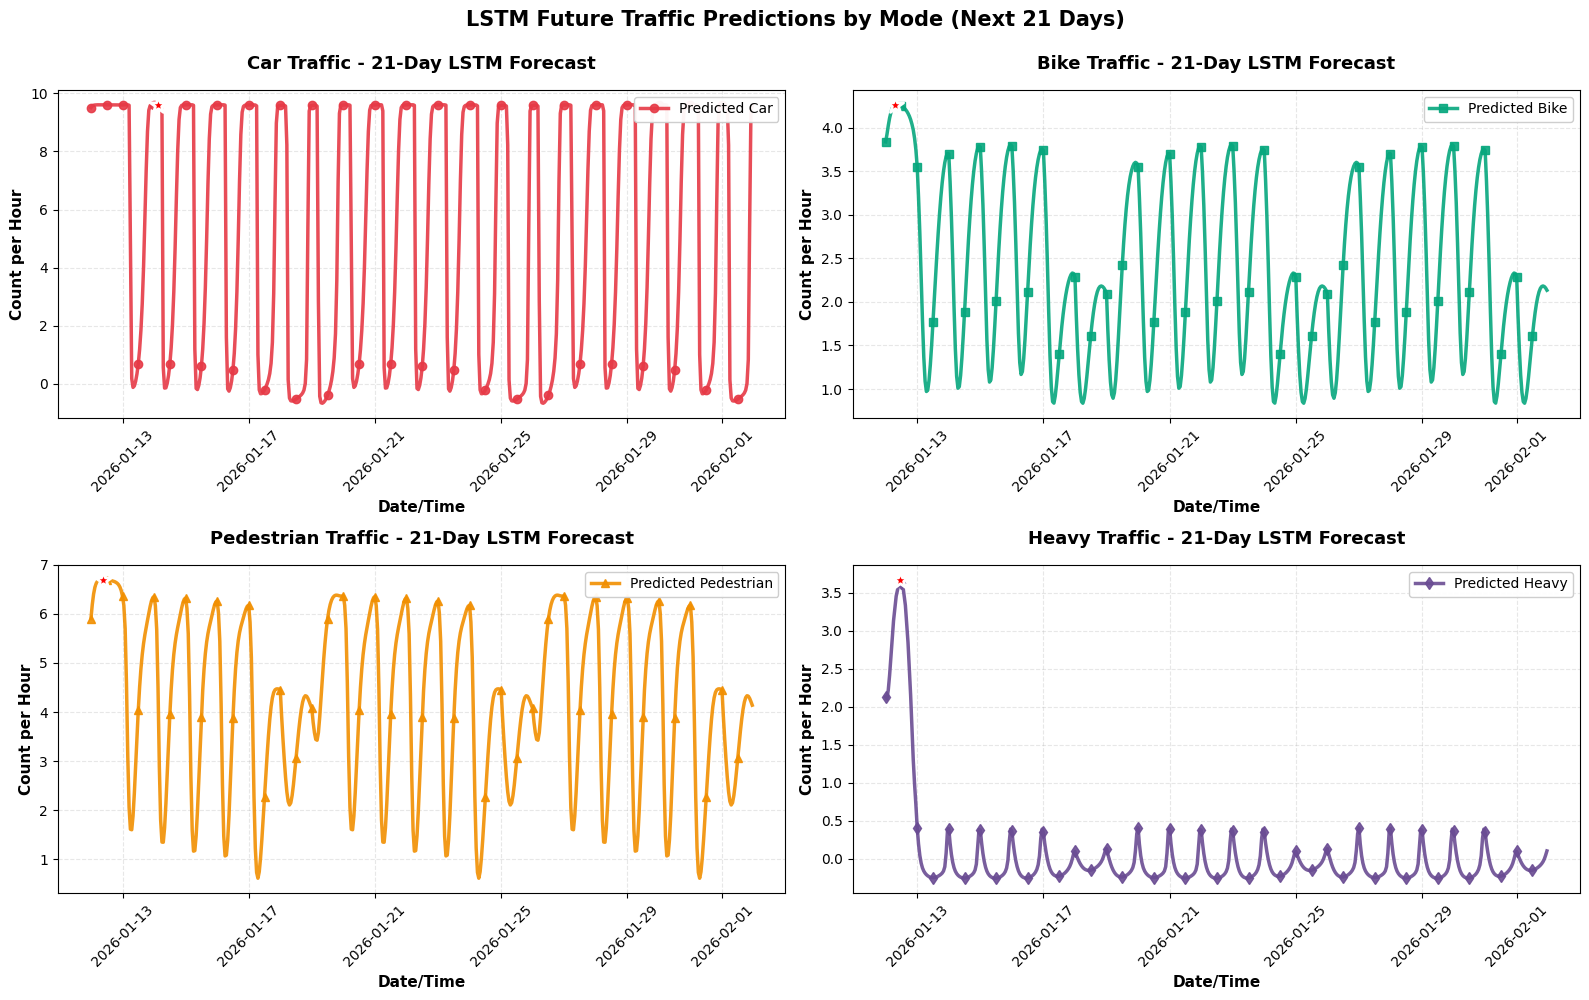

In [31]:
# UPDATED: Future predictions with dynamic horizon in titles
# Calculate horizon from predictions
horizon_days = len(future_preds) // 24

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

colors_mode = {'car': '#E63946', 'bike': '#06A77D', 'pedestrian': '#F18F01', 'heavy': '#6A4C93'}
markers_mode = {'car': 'o', 'bike': 's', 'pedestrian': '^', 'heavy': 'd'}

for idx, mode in enumerate(modes):
    axes[idx].plot(future_preds["datetime"], 
                   future_preds[f"pred_{mode}"],
                   color=colors_mode[mode],
                   linewidth=2.5,
                   marker=markers_mode[mode],
                   markersize=6,
                   markevery=12,
                   alpha=0.9,
                   label=f'Predicted {mode.capitalize()}')
    
    axes[idx].set_xlabel('Date/Time', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Count per Hour', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'{mode.capitalize()} Traffic - {horizon_days}-Day LSTM Forecast', 
                       fontweight='bold', fontsize=13, pad=15)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend(fontsize=10, loc='upper right', framealpha=0.95)
    
    # Add peak annotation
    max_val = future_preds[f"pred_{mode}"].max()
    max_idx = future_preds[f"pred_{mode}"].idxmax()
    max_time = future_preds.loc[max_idx, "datetime"]
    
    axes[idx].scatter([max_time], [max_val], color='red', s=150, 
                     zorder=5, edgecolors='white', linewidth=2, marker='*')

fig.suptitle(f'LSTM Future Traffic Predictions by Mode (Next {horizon_days} Days)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

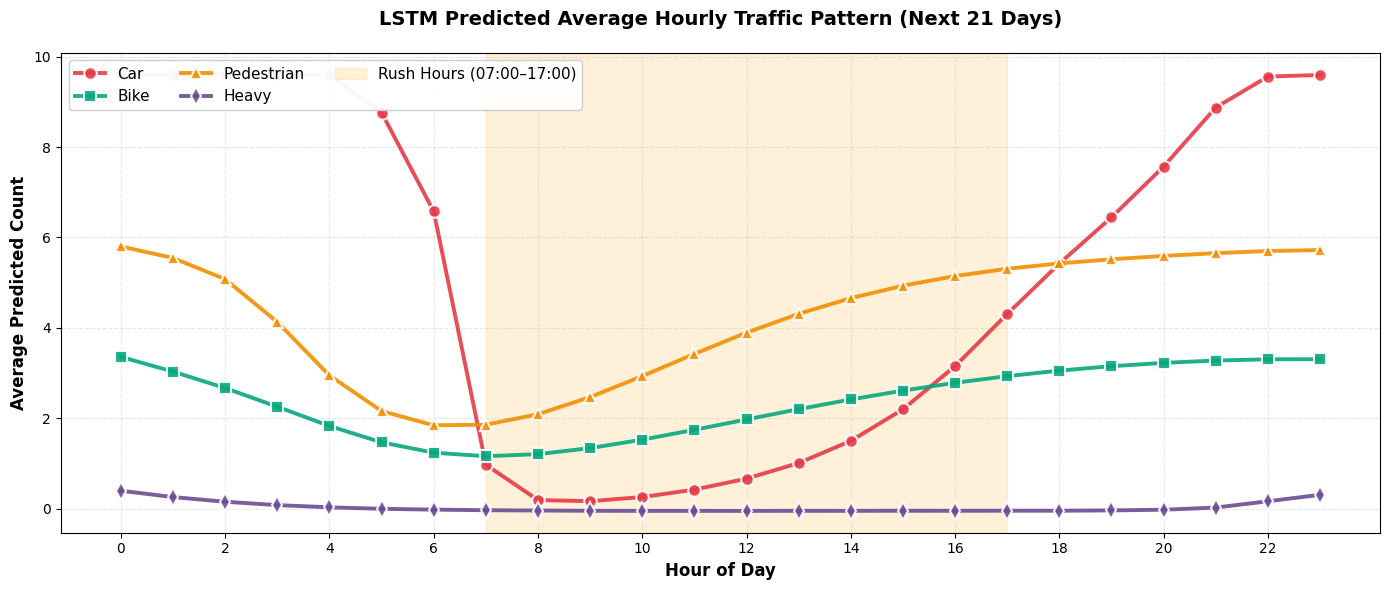

In [32]:
# UPDATED: Hourly average with dynamic horizon
horizon_days = len(future_preds) // 24
future_hourly = future_preds.groupby("hour")[[f"pred_{m}" for m in modes]].mean()

plt.figure(figsize=(14, 6))

for mode in modes:
    plt.plot(future_hourly.index, 
             future_hourly[f"pred_{mode}"],
             color=colors_mode[mode],
             marker=markers_mode[mode],
             linewidth=2.8,
             markersize=9,
             label=f'{mode.capitalize()}',
             markeredgecolor='white',
             markeredgewidth=1.5,
             alpha=0.9)

plt.xlabel('Hour of Day', fontweight='bold', fontsize=12)
plt.ylabel('Average Predicted Count', fontweight='bold', fontsize=12)
plt.title(f'LSTM Predicted Average Hourly Traffic Pattern (Next {horizon_days} Days)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(0, 24, 2), fontsize=10)

# Shade rush hours using configured constants
plt.axvspan(RUSH_HOUR_START, RUSH_HOUR_END, alpha=0.15, color='orange', 
           label=f'Rush Hours ({RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00)')

plt.legend(fontsize=11, loc='upper left', framealpha=0.95, ncol=3)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

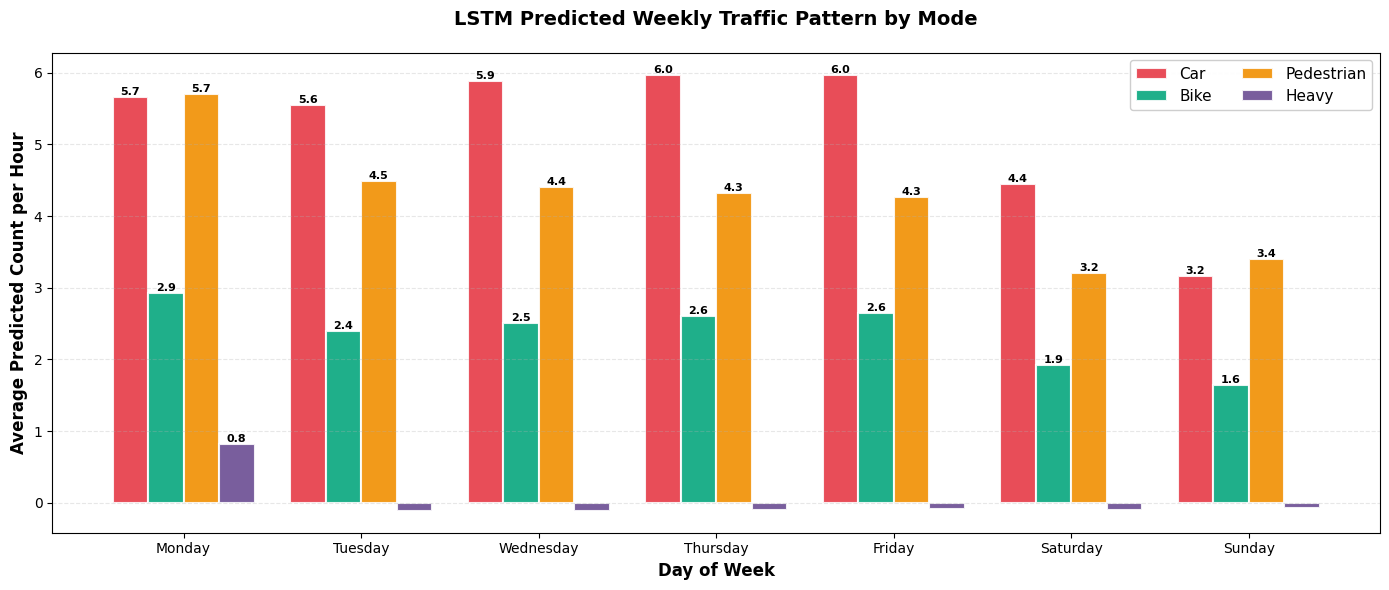

In [33]:
# Day-of-week pattern for future predictions
future_preds["day_name"] = future_preds["datetime"].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

future_daily = future_preds.groupby("day_name")[[f"pred_{m}" for m in modes]].mean()
future_daily = future_daily.reindex(day_order)

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(day_order))
width = 0.2

for i, mode in enumerate(modes):
    offset = (i - len(modes)/2 + 0.5) * width
    bars = ax.bar(x + offset, 
                  future_daily[f"pred_{mode}"], 
                  width, 
                  label=mode.capitalize(),
                  color=colors_mode[mode],
                  edgecolor='white',
                  linewidth=1.5,
                  alpha=0.9)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0.5:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', 
                   fontweight='bold', fontsize=8)

ax.set_xlabel('Day of Week', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Predicted Count per Hour', fontweight='bold', fontsize=12)
ax.set_title('LSTM Predicted Weekly Traffic Pattern by Mode', 
            fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(day_order, fontsize=10)
ax.legend(fontsize=11, loc='upper right', framealpha=0.95, ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [34]:
# UPDATED: Summary statistics with dynamic horizon
horizon_days = len(future_preds) // 24

summary_stats = pd.DataFrame({
    'Mode': [m.capitalize() for m in modes],
    'Mean': [future_preds[f"pred_{m}"].mean() for m in modes],
    'Std Dev': [future_preds[f"pred_{m}"].std() for m in modes],
    'Min': [future_preds[f"pred_{m}"].min() for m in modes],
    'Max': [future_preds[f"pred_{m}"].max() for m in modes],
    f'Total ({horizon_days} days)': [future_preds[f"pred_{m}"].sum() for m in modes]
})

print("\n" + "="*70)
print(f"LSTM FUTURE TRAFFIC PREDICTIONS SUMMARY (Next {horizon_days} Days)")
print("="*70)
print(summary_stats.to_string(index=False))
print("="*70)


LSTM FUTURE TRAFFIC PREDICTIONS SUMMARY (Next 21 Days)
      Mode     Mean  Std Dev       Min      Max  Total (21 days)
       Car 5.235404 4.412757 -0.671635 9.608141      2638.643799
      Bike 2.378389 1.002177  0.836715 4.261939      1198.708252
Pedestrian 4.255968 1.733996  0.610052 6.697297      2145.007812
     Heavy 0.033252 0.644160 -0.256229 3.668831        16.758797


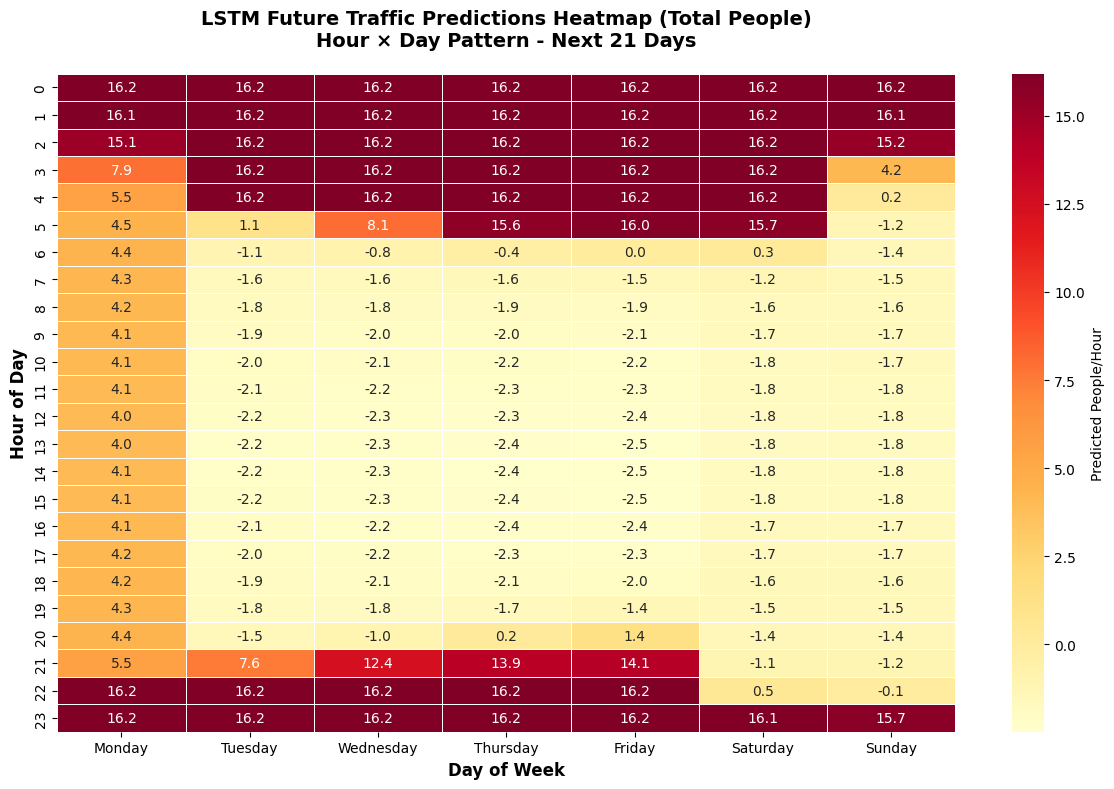

In [35]:
# UPDATED: Heatmap with dynamic horizon
horizon_days = len(future_preds) // 24

# Make sure day_name exists
if "day_name" not in future_preds.columns:
    future_preds["day_name"] = future_preds["datetime"].dt.day_name()

heatmap_data = future_preds.pivot_table(
    values="pred_total_people",
    index="hour",
    columns="day_name",
    aggfunc="mean"
)

# Reorder columns Monday → Sunday (only those that exist)
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
available_days = [d for d in day_order if d in heatmap_data.columns]
heatmap_data = heatmap_data[available_days]

plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap="YlOrRd",
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Predicted People/Hour"},
    linewidths=0.5,
    linecolor="white",
)

plt.xlabel("Day of Week", fontweight="bold", fontsize=12)
plt.ylabel("Hour of Day", fontweight="bold", fontsize=12)
plt.title(
    f"LSTM Future Traffic Predictions Heatmap (Total People)\n"
    f"Hour × Day Pattern - Next {horizon_days} Days",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
plt.show()


## Parking Scenario Analysis (LSTM-Based)

Evaluating the impact of different parking policies on **LSTM-predicted** traffic patterns. This analysis uses the exact same scenario logic as the Random Forest notebook, but applies it to deep learning predictions.

### Parking Scenarios:

1. **Open Parking (Baseline)**: Current situation with free and available parking
2. **Closed Parking**: Complete parking restriction:
   - 50% reduction in car traffic
   - 40% increase in bicycle usage
   - 30% increase in pedestrian traffic
3. **Paid Parking**: Introduction of parking fees:
   - 20% reduction in car traffic
   - 20% increase in bicycle usage
   - 5% increase in pedestrian traffic

**Note**: These adjustment factors are applied to **LSTM model predictions**, not Random Forest outputs. The scenario logic is identical to the RandomForestRegressor notebook.

In [36]:
def adjust_for_parking(row, scenario):
    """
    Apply parking scenario adjustment factors to predicted traffic.
    
    Parameters:
    -----------
    row : pd.Series
        Row with predicted values for each mode
    scenario : str
        'open', 'closed', or 'paid'
        
    Returns:
    --------
    pd.Series with adjusted values
    """
    car = row["pred_car"]
    bike = row["pred_bike"]
    ped = row["pred_pedestrian"]
    heavy = row["pred_heavy"]

    if scenario == "closed":
        car *= 0.5
        bike *= 1.40
        ped *= 1.30
    elif scenario == "paid":
        car *= 0.80
        bike *= 1.20
        ped *= 1.05
    # if scenario == "open": keep original values

    total = car + bike + ped + heavy

    return pd.Series({
        "car": car,
        "bike": bike,
        "pedestrian": ped,
        "heavy": heavy,
        "total_people": total,
    })

print("Parking adjustment function defined.")

Parking adjustment function defined.


In [37]:
# Generate scenarios
scenario_frames = []

for scenario in ["open", "closed", "paid"]:
    adjusted = future_preds.apply(
        adjust_for_parking, axis=1, scenario=scenario
    )
    adjusted["scenario"] = scenario
    adjusted["datetime"] = future_preds["datetime"].values
    adjusted["street_name"] = "Sintmartenslatemlaan"
    scenario_frames.append(adjusted)

scenario_df = pd.concat(scenario_frames, ignore_index=True)

print(f"Scenario dataframe created: {scenario_df.shape}")
scenario_df.head()

Scenario dataframe created: (1512, 8)


car      bike  pedestrian     heavy  total_people scenario  \
0  9.510274  3.836535    5.906991  2.125510     21.379311     open   
1  9.567666  3.921786    6.192081  2.102999     21.784533     open   
2  9.590672  4.022681    6.405797  2.220479     22.239630     open   
3  9.600062  4.109227    6.544827  2.413740     22.667857     open   
4  9.603924  4.172749    6.624395  2.651289     23.052357     open   

             datetime           street_name  
0 2026-01-11 23:00:00  Sintmartenslatemlaan  
1 2026-01-12 00:00:00  Sintmartenslatemlaan  
2 2026-01-12 01:00:00  Sintmartenslatemlaan  
3 2026-01-12 02:00:00  Sintmartenslatemlaan  
4 2026-01-12 03:00:00  Sintmartenslatemlaan

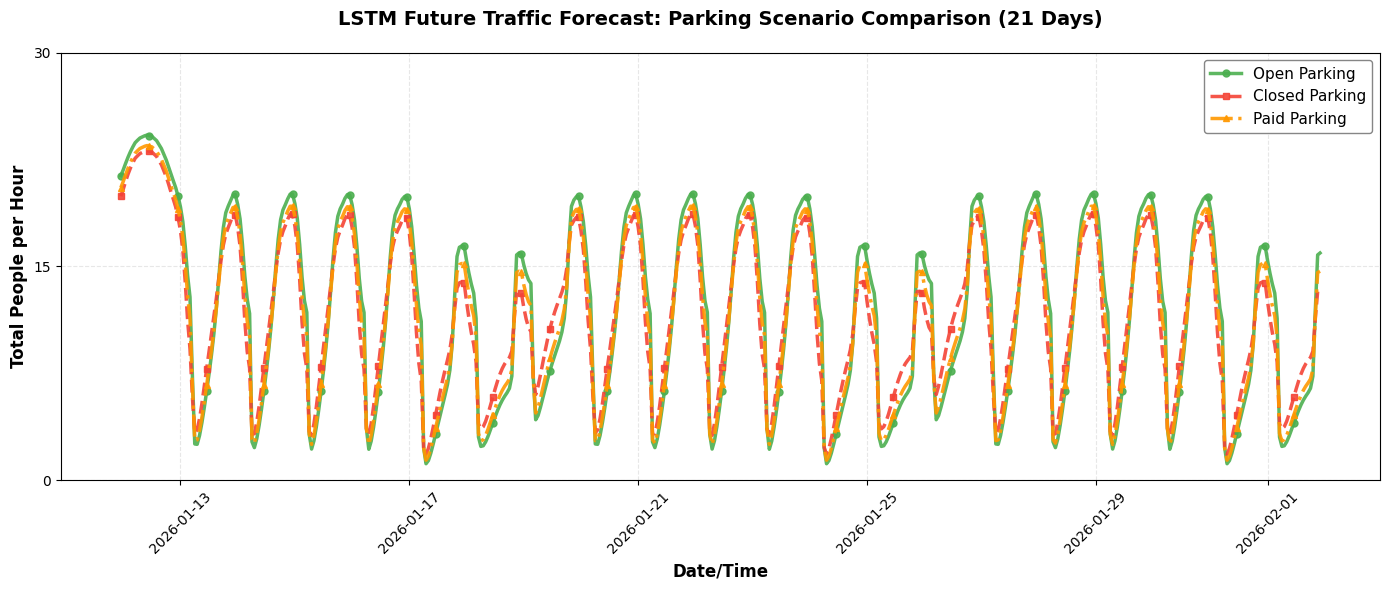

Note: Parking scenarios use LSTM predictions with same adjustment factors as RF notebook


In [38]:
# UPDATED: Comparison of total traffic across scenarios (LSTM-based)
horizon_days = len(scenario_df[scenario_df["scenario"]=="open"]) // 24

plt.figure(figsize=(14, 6))

scenario_styles = {
    'open': {'color': '#4CAF50', 'linestyle': '-', 'linewidth': 2.5, 'marker': 'o', 'label': 'Open Parking'},
    'closed': {'color': '#F44336', 'linestyle': '--', 'linewidth': 2.5, 'marker': 's', 'label': 'Closed Parking'},
    'paid': {'color': '#FF9800', 'linestyle': '-.', 'linewidth': 2.5, 'marker': '^', 'label': 'Paid Parking'}
}

for scenario in ['open', 'closed', 'paid']:
    sub = scenario_df[scenario_df["scenario"] == scenario]
    style = scenario_styles[scenario]
    plt.plot(sub["datetime"], sub["total_people"],
             label=style['label'],
             color=style['color'],
             linestyle=style['linestyle'],
             linewidth=style['linewidth'],
             marker=style['marker'],
             markersize=5,
             markevery=12,
             alpha=0.9)

plt.xlabel("Date/Time", fontsize=12, fontweight='bold')
plt.ylabel("Total People per Hour", fontsize=12, fontweight='bold')
plt.title(f"LSTM Future Traffic Forecast: Parking Scenario Comparison ({horizon_days} Days)", 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best', framealpha=0.95, edgecolor='gray')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

max_y = scenario_df["total_people"].max()
plt.yticks(np.arange(0, max_y + 10, 15))

plt.tight_layout()
plt.show()

print("Note: Parking scenarios use LSTM predictions with same adjustment factors as RF notebook")

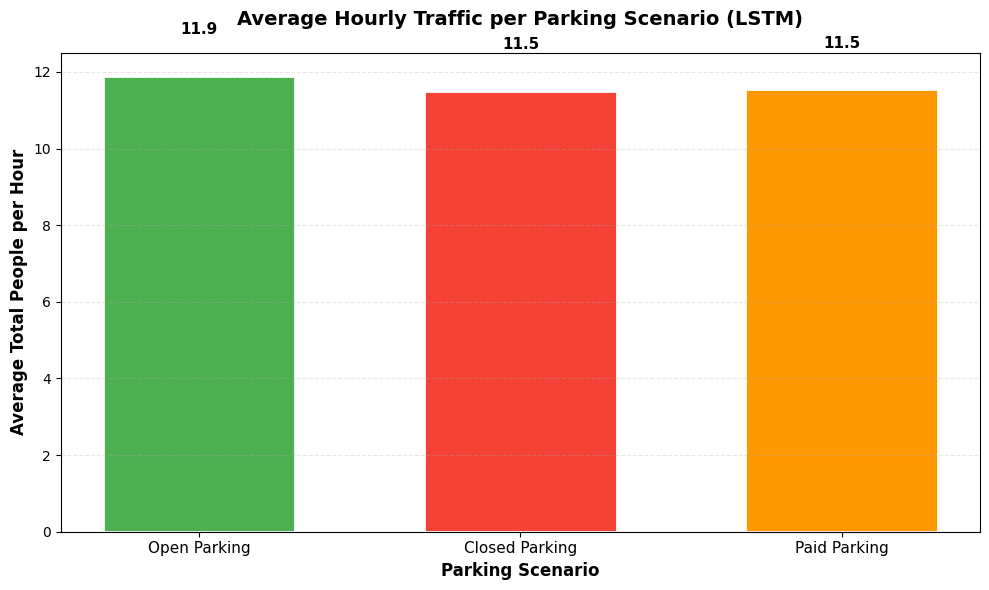

In [39]:
# Average total traffic per scenario
mean_open   = scenario_df[scenario_df["scenario"]=="open"]["total_people"].mean()
mean_closed = scenario_df[scenario_df["scenario"]=="closed"]["total_people"].mean()
mean_paid   = scenario_df[scenario_df["scenario"]=="paid"]["total_people"].mean()

avg_totals = pd.Series(
    [mean_open, mean_closed, mean_paid],
    index=["Open","Closed","Paid"]
)

plt.figure(figsize=(10, 6))
colors = ["#4CAF50","#F44336","#FF9800"]
bars = plt.bar(range(3), avg_totals, color=colors, edgecolor='white', linewidth=2, width=0.6)

plt.xticks(range(3), ["Open Parking", "Closed Parking", "Paid Parking"], fontsize=11)
plt.ylabel("Average Total People per Hour", fontsize=12, fontweight='bold')
plt.xlabel("Parking Scenario", fontsize=12, fontweight='bold')
plt.title("Average Hourly Traffic per Parking Scenario (LSTM)", fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

for i, v in enumerate(avg_totals):
    plt.text(i, v + 1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

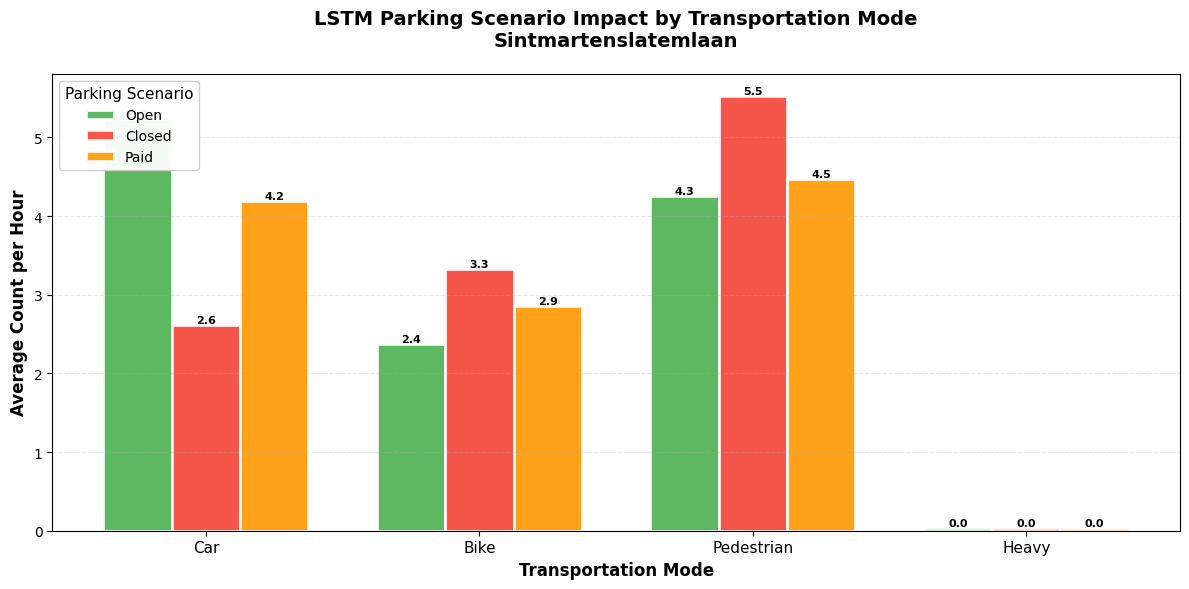

In [40]:
# Impact comparison by mode
avg_mode_scen = scenario_df.groupby("scenario")[modes].mean().T

fig, ax = plt.subplots(figsize=(12, 6))

scenario_colors = {'open': '#4CAF50', 'closed': '#F44336', 'paid': '#FF9800'}
x = np.arange(len(modes))
width = 0.25

for i, scenario in enumerate(['open', 'closed', 'paid']):
    offset = (i - 1) * width
    bars = ax.bar(x + offset, avg_mode_scen[scenario], width, 
                  label=scenario.capitalize(), 
                  color=scenario_colors[scenario],
                  edgecolor='white',
                  linewidth=2,
                  alpha=0.9)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}',
               ha='center', va='bottom', fontweight='bold', fontsize=8)

ax.set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Count per Hour', fontweight='bold', fontsize=12)
ax.set_title('LSTM Parking Scenario Impact by Transportation Mode\nSintmartenslatemlaan', 
            fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in modes], fontsize=11)
ax.legend(title='Parking Scenario', fontsize=10, title_fontsize=11, 
         loc='upper left', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

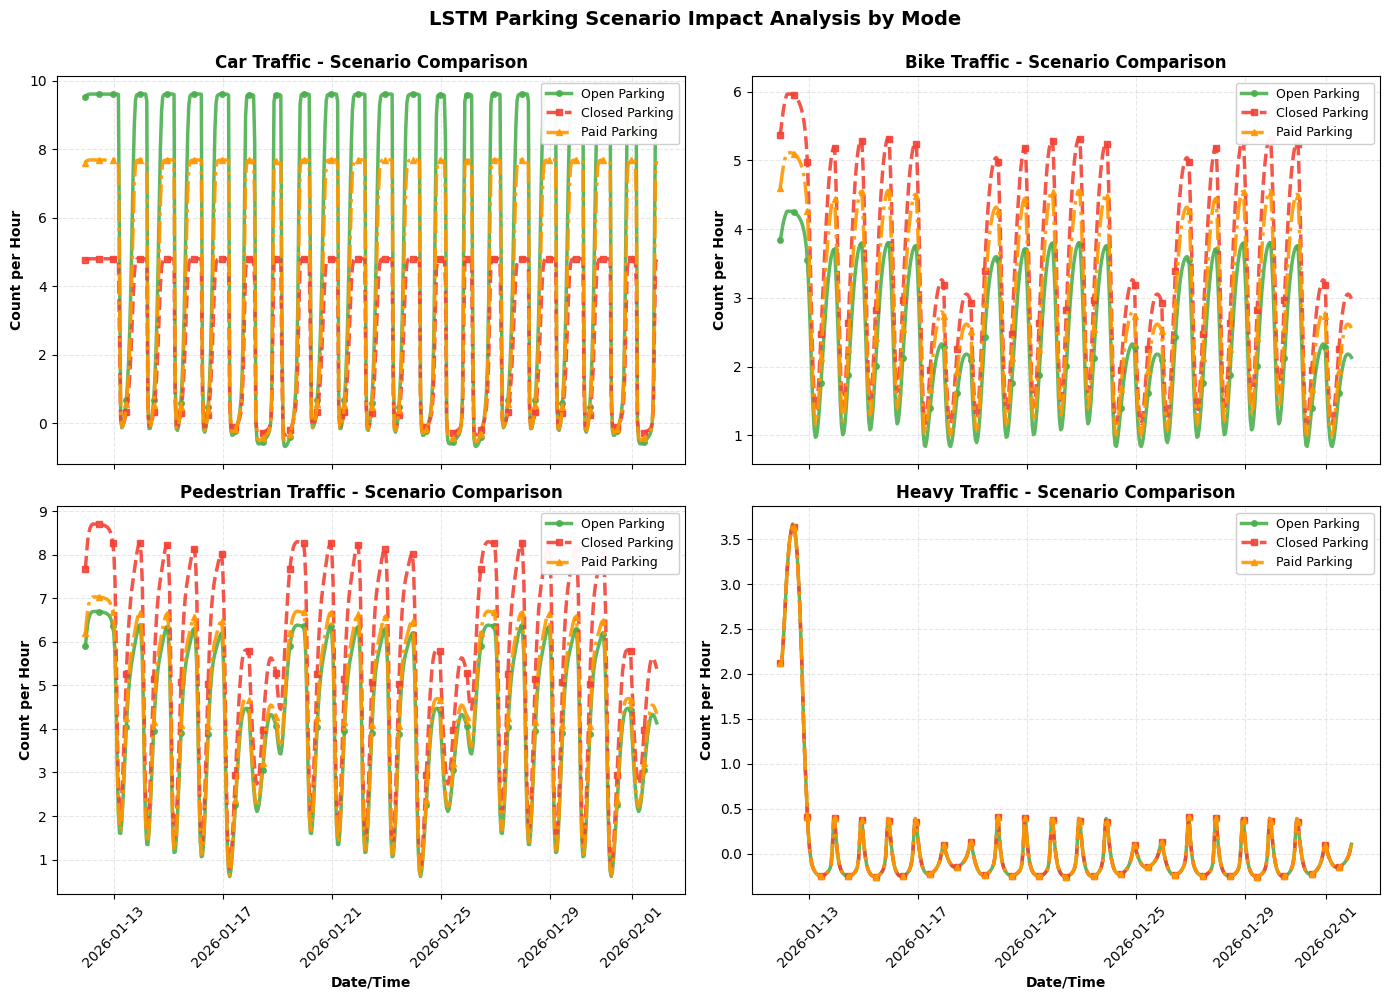

In [41]:
# Mode-specific impact - individual plots for each scenario
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.ravel()

for ax, m in zip(axes, modes):
    for scenario in ['open', 'closed', 'paid']:
        sub = scenario_df[scenario_df["scenario"] == scenario]
        style = scenario_styles[scenario]
        
        ax.plot(sub["datetime"], sub[m], 
               label=style['label'],
               color=style['color'],
               linestyle=style['linestyle'],
               linewidth=2.5,
               marker=style['marker'],
               markersize=4,
               markevery=12,
               alpha=0.9)
    
    ax.set_title(f'{m.capitalize()} Traffic - Scenario Comparison', 
                fontweight='bold', fontsize=12)
    ax.set_ylabel('Count per Hour', fontweight='bold', fontsize=10)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=45)

axes[2].set_xlabel('Date/Time', fontweight='bold', fontsize=10)
axes[3].set_xlabel('Date/Time', fontweight='bold', fontsize=10)

fig.suptitle('LSTM Parking Scenario Impact Analysis by Mode', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [42]:
# UPDATED: Summary statistics comparison (LSTM-based)
# Calculate horizon days from the data
horizon_days = len(scenario_df[scenario_df["scenario"]=="open"]) // 24

print("\n" + "="*80)
print("PARKING SCENARIO IMPACT SUMMARY")
print("Based on LSTM Predictions (Same Logic as Random Forest Notebook)")
print("="*80)

for scenario in ['open', 'closed', 'paid']:
    sub = scenario_df[scenario_df["scenario"] == scenario]
    print(f"\n{scenario.upper()} PARKING:")
    print("-" * 80)
    
    for mode in modes + ['total_people']:
        mean_val = sub[mode].mean()
        total_val = sub[mode].sum()
        print(f"  {mode.capitalize():15s}: Mean = {mean_val:6.2f}/hr, Total ({horizon_days} days) = {total_val:8.1f}")

print("\n" + "="*80)

# Calculate differences from baseline
print("\nCHANGE FROM OPEN PARKING BASELINE (LSTM-Based):")
print("="*80)

open_avg = scenario_df[scenario_df["scenario"]=="open"][modes + ['total_people']].mean()

for scenario in ['closed', 'paid']:
    sub_avg = scenario_df[scenario_df["scenario"]==scenario][modes + ['total_people']].mean()
    diff = sub_avg - open_avg
    pct_change = (diff / open_avg * 100)
    
    print(f"\n{scenario.upper()} PARKING vs OPEN:")
    print("-" * 80)
    for mode in modes + ['total_people']:
        print(f"  {mode.capitalize():15s}: {diff[mode]:+6.2f}/hr ({pct_change[mode]:+5.1f}%)")

print("\n" + "="*80)
print("✓ Scenario analysis complete using LSTM predictions")
print("="*80)


PARKING SCENARIO IMPACT SUMMARY
Based on LSTM Predictions (Same Logic as Random Forest Notebook)

OPEN PARKING:
--------------------------------------------------------------------------------
  Car            : Mean =   5.24/hr, Total (21 days) =   2638.6
  Bike           : Mean =   2.38/hr, Total (21 days) =   1198.7
  Pedestrian     : Mean =   4.26/hr, Total (21 days) =   2145.0
  Heavy          : Mean =   0.03/hr, Total (21 days) =     16.8
  Total_people   : Mean =  11.90/hr, Total (21 days) =   5999.1

CLOSED PARKING:
--------------------------------------------------------------------------------
  Car            : Mean =   2.62/hr, Total (21 days) =   1319.3
  Bike           : Mean =   3.33/hr, Total (21 days) =   1678.2
  Pedestrian     : Mean =   5.53/hr, Total (21 days) =   2788.5
  Heavy          : Mean =   0.03/hr, Total (21 days) =     16.8
  Total_people   : Mean =  11.51/hr, Total (21 days) =   5802.8

PAID PARKING:
-----------------------------------------------------

In [43]:
# NEW: Reproducibility configuration cell
print("="*70)
print("LSTM TRAFFIC ANALYSIS - CONFIGURATION")
print("="*70)
print(f"\n📊 Random Seed: {RANDOM_SEED}")
print(f"\n🔧 LSTM Hyperparameters:")
print(f"   - Lookback window: Not yet defined (will be set to 24 hours)")
print(f"   - LSTM Units Layer 1: 64")
print(f"   - LSTM Units Layer 2: 32")
print(f"   - Dropout rate: 0.2")
print(f"   - Learning rate: 0.001")
print(f"   - Batch size: 32")
print(f"   - Max epochs: 50")
print(f"   - Early stopping patience: 10")

print(f"\n📁 Data Configuration:")
print(f"   - Input file: ../data/traffic_weather_merged.csv")
print(f"   - Train/Test split: 80/20 (time-ordered, no shuffle)")
print(f"   - Validation split: 20% of training data")

print(f"\n🎯 Target Variables:")
print(f"   - Transportation modes: car, bike, pedestrian, heavy")
print(f"   - Aggregate: total_people")

print(f"\n📐 Feature Set (10 features):")
print(f"   - Temporal: hour, dayofweek, is_weekend")
print(f"   - Calendar: is_holiday, is_school_vacation")
print(f"   - Weather: temperature_c, precipitation_mm, cloud_cover_pct, wind_speed_kmh")
print(f"   - Location: street_code")

print("\n" + "="*70)

LSTM TRAFFIC ANALYSIS - CONFIGURATION

📊 Random Seed: 42

🔧 LSTM Hyperparameters:
   - Lookback window: Not yet defined (will be set to 24 hours)
   - LSTM Units Layer 1: 64
   - LSTM Units Layer 2: 32
   - Dropout rate: 0.2
   - Learning rate: 0.001
   - Batch size: 32
   - Max epochs: 50
   - Early stopping patience: 10

📁 Data Configuration:
   - Input file: ../data/traffic_weather_merged.csv
   - Train/Test split: 80/20 (time-ordered, no shuffle)
   - Validation split: 20% of training data

🎯 Target Variables:
   - Transportation modes: car, bike, pedestrian, heavy
   - Aggregate: total_people

📐 Feature Set (10 features):
   - Temporal: hour, dayofweek, is_weekend
   - Calendar: is_holiday, is_school_vacation
   - Weather: temperature_c, precipitation_mm, cloud_cover_pct, wind_speed_kmh
   - Location: street_code



In [44]:
# NEW: Calculate persistence baseline metrics
baseline_metrics = {}

print("Computing Persistence Baseline Metrics...")
print("="*70)

for target in targets:
    X = sequences_dict[target]['X_scaled']
    y = sequences_dict[target]['y']
    
    # Split same way as LSTM
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Persistence baseline: predict last known value from sequence
    # For each test sample, use the last value from its lookback window
    indices = sequences_dict[target]['indices']
    test_indices = indices[len(y_train):]
    
    # Get the persistence predictions (t-1 predicts t)
    y_baseline = []
    for idx in test_indices:
        # Last value in the sequence (t-1)
        y_baseline.append(df_model[target].iloc[idx-1])
    y_baseline = np.array(y_baseline)
    
    # Calculate metrics
    mae_baseline = mean_absolute_error(y_test, y_baseline)
    rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline))
    r2_baseline = r2_score(y_test, y_baseline)
    
    baseline_metrics[target] = {
        'mae': mae_baseline,
        'rmse': rmse_baseline,
        'r2': r2_baseline
    }
    
    print(f"{target:15s}: MAE={mae_baseline:.3f}, RMSE={rmse_baseline:.3f}, R²={r2_baseline:.3f}")

print("="*70)

Computing Persistence Baseline Metrics...
car            : MAE=4.673, RMSE=9.956, R²=-0.341
bike           : MAE=1.071, RMSE=3.044, R²=-0.818
heavy          : MAE=1.013, RMSE=3.040, R²=-0.598
pedestrian     : MAE=1.279, RMSE=3.456, R²=0.698
total_people   : MAE=6.182, RMSE=13.235, R²=0.294


In [45]:
# NEW: Calculate LSTM R² scores for comparison
print("Computing LSTM Model Metrics with R²...")
print("="*70)

for target in targets:
    X = sequences_dict[target]['X_scaled']
    y = sequences_dict[target]['y']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models[target].predict(X_test, verbose=0).flatten()
    
    # Calculate R²
    r2_lstm = r2_score(y_test, y_pred)
    metrics[target]['r2'] = r2_lstm
    
    print(f"{target:15s}: MAE={metrics[target]['mae']:.3f}, RMSE={metrics[target]['rmse']:.3f}, R²={r2_lstm:.3f}")

print("="*70)

Computing LSTM Model Metrics with R²...
car            : MAE=3.787, RMSE=7.309, R²=0.277
bike           : MAE=1.180, RMSE=2.270, R²=-0.012
heavy          : MAE=1.023, RMSE=2.454, R²=-0.041
pedestrian     : MAE=2.326, RMSE=6.220, R²=0.022
total_people   : MAE=7.040, RMSE=13.568, R²=0.258


In [46]:
# NEW: Side-by-side comparison table
comparison_data = []

for target in targets:
    comparison_data.append({
        'Mode': target.capitalize(),
        'Baseline MAE': baseline_metrics[target]['mae'],
        'LSTM MAE': metrics[target]['mae'],
        'Baseline RMSE': baseline_metrics[target]['rmse'],
        'LSTM RMSE': metrics[target]['rmse'],
        'Baseline R²': baseline_metrics[target]['r2'],
        'LSTM R²': metrics[target]['r2'],
        'MAE Improvement (%)': ((baseline_metrics[target]['mae'] - metrics[target]['mae']) / baseline_metrics[target]['mae'] * 100)
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("BASELINE vs LSTM PERFORMANCE COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)
print("\n📊 Interpretation:")
print("   - Positive 'MAE Improvement %' means LSTM performs better than baseline")
print("   - Higher R² values indicate better predictive performance")
print("   - LSTM captures temporal patterns that persistence baseline misses")
print("="*90)


BASELINE vs LSTM PERFORMANCE COMPARISON
        Mode  Baseline MAE  LSTM MAE  Baseline RMSE  LSTM RMSE  Baseline R²   LSTM R²  MAE Improvement (%)
         Car      4.672742  3.787063       9.955933   7.308547    -0.341240  0.277223            18.954147
        Bike      1.071139  1.179642       3.043890   2.270337    -0.818223 -0.011510           -10.129655
       Heavy      1.013448  1.022565       3.040445   2.453609    -0.597785 -0.040531            -0.899537
  Pedestrian      1.278831  2.326360       3.455737   6.220445     0.698160  0.022001           -81.912985
Total_people      6.181549  7.040059      13.235318  13.568127     0.294352  0.258418           -13.888264

📊 Interpretation:
   - Positive 'MAE Improvement %' means LSTM performs better than baseline
   - Higher R² values indicate better predictive performance
   - LSTM captures temporal patterns that persistence baseline misses


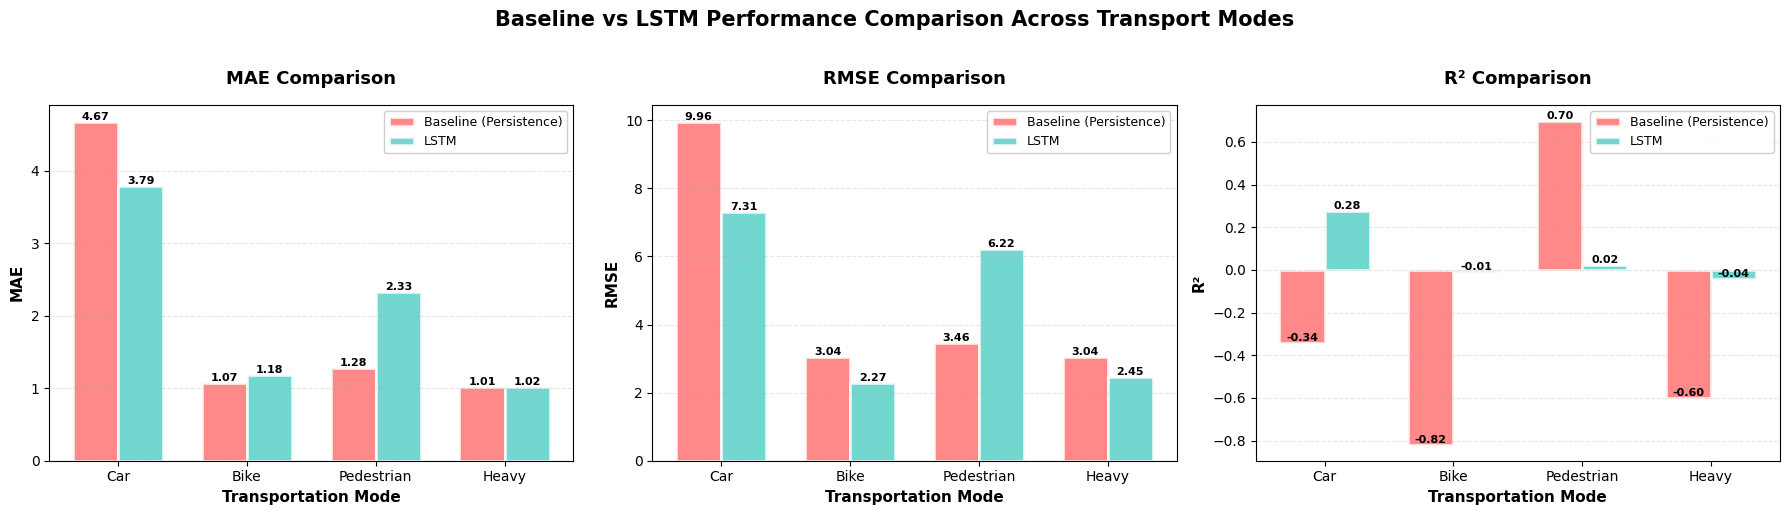

In [47]:
# NEW: Visualization of baseline vs LSTM comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['MAE', 'RMSE', 'R²']
metric_keys = [('Baseline MAE', 'LSTM MAE'), 
               ('Baseline RMSE', 'LSTM RMSE'), 
               ('Baseline R²', 'LSTM R²')]

for ax, metric_name, (base_key, lstm_key) in zip(axes, metrics_to_plot, metric_keys):
    x = np.arange(len(modes))
    width = 0.35
    
    baseline_vals = [comparison_df[comparison_df['Mode']==m.capitalize()][base_key].values[0] 
                     for m in modes]
    lstm_vals = [comparison_df[comparison_df['Mode']==m.capitalize()][lstm_key].values[0] 
                 for m in modes]
    
    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (Persistence)', 
                  color='#FF6B6B', edgecolor='white', linewidth=2, alpha=0.8)
    bars2 = ax.bar(x + width/2, lstm_vals, width, label='LSTM', 
                  color='#4ECDC4', edgecolor='white', linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Transportation Mode', fontweight='bold', fontsize=11)
    ax.set_ylabel(metric_name, fontweight='bold', fontsize=11)
    ax.set_title(f'{metric_name} Comparison', fontweight='bold', fontsize=13, pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels([m.capitalize() for m in modes], fontsize=10)
    ax.legend(fontsize=9, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', 
                   fontweight='bold', fontsize=8)

fig.suptitle('Baseline vs LSTM Performance Comparison Across Transport Modes', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Error Analysis & Model Diagnostics

Analyzing prediction errors to understand model behavior and identify potential improvements.

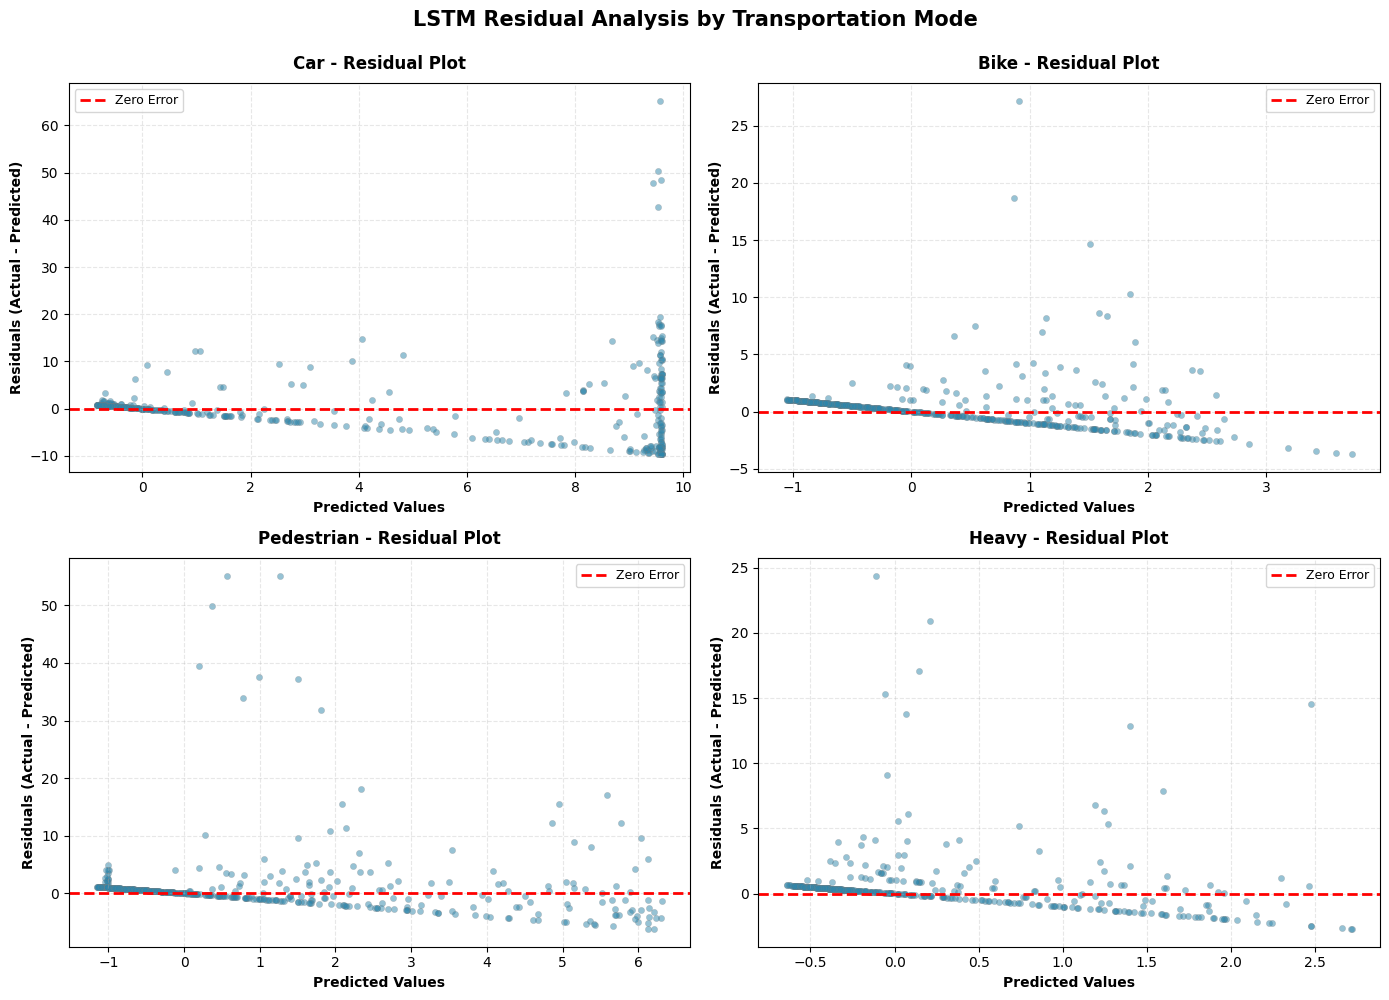

In [48]:
# NEW: Residual plots for error analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, mode in enumerate(modes):
    X = sequences_dict[mode]['X_scaled']
    y = sequences_dict[mode]['y']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models[mode].predict(X_test, verbose=0).flatten()
    residuals = y_test - y_pred
    
    # Residual plot
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20, 
                     color='#2E86AB', edgecolors='gray', linewidth=0.3)
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[idx].set_xlabel('Predicted Values', fontweight='bold', fontsize=10)
    axes[idx].set_ylabel('Residuals (Actual - Predicted)', fontweight='bold', fontsize=10)
    axes[idx].set_title(f'{mode.capitalize()} - Residual Plot', 
                       fontweight='bold', fontsize=12, pad=10)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3, linestyle='--')

fig.suptitle('LSTM Residual Analysis by Transportation Mode', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

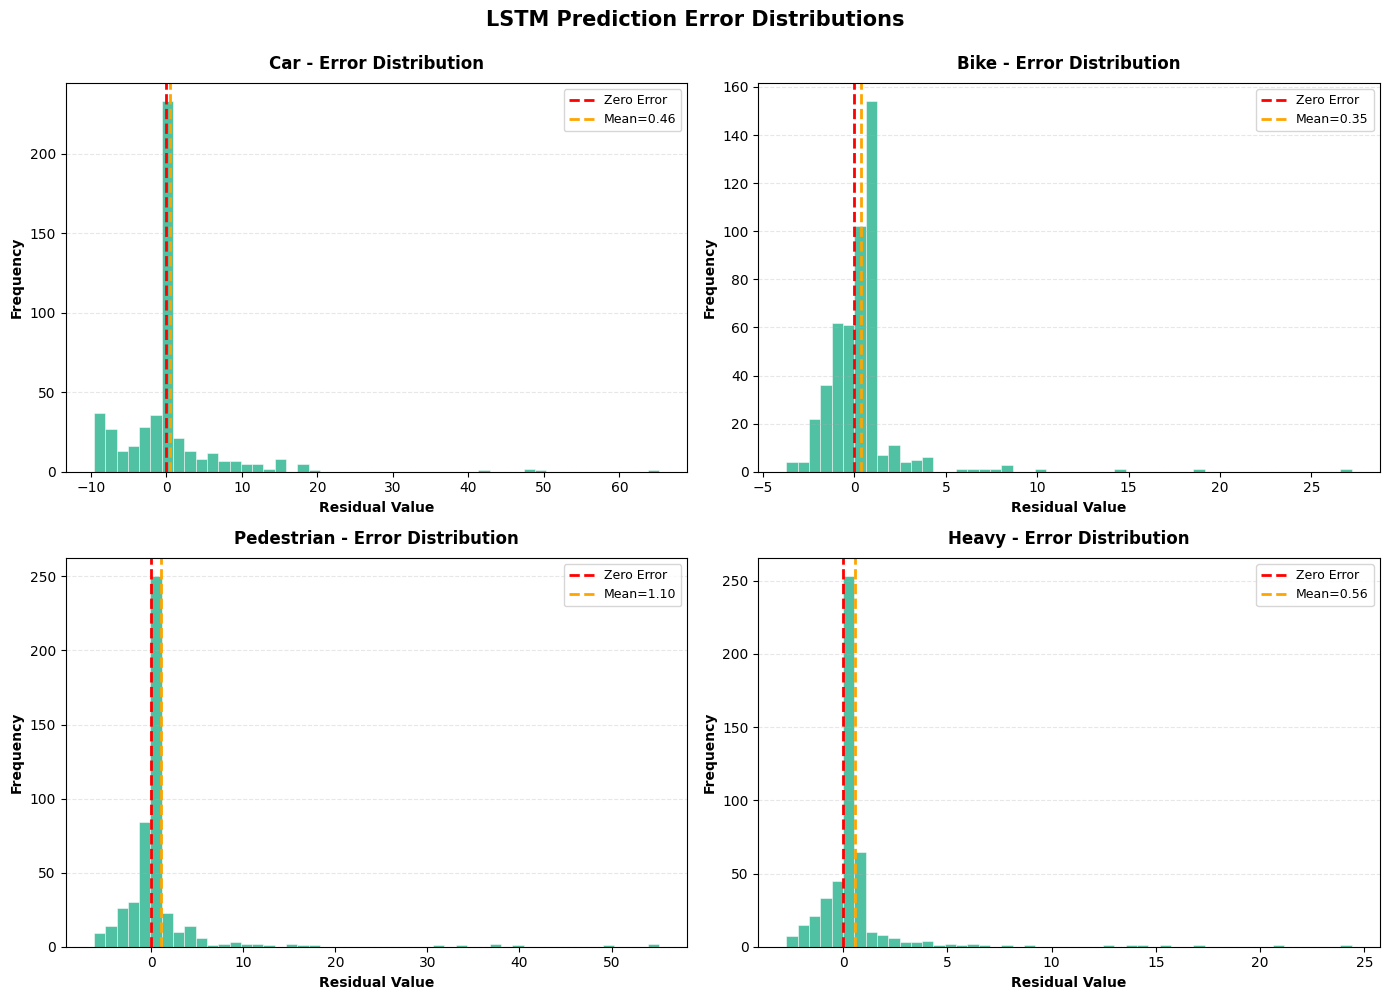

In [49]:
# NEW: Error distribution histograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, mode in enumerate(modes):
    X = sequences_dict[mode]['X_scaled']
    y = sequences_dict[mode]['y']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models[mode].predict(X_test, verbose=0).flatten()
    residuals = y_test - y_pred
    
    # Histogram of residuals
    axes[idx].hist(residuals, bins=50, color='#06A77D', alpha=0.7, edgecolor='white', linewidth=0.5)
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    axes[idx].axvline(x=residuals.mean(), color='orange', linestyle='--', linewidth=2, 
                     label=f'Mean={residuals.mean():.2f}')
    axes[idx].set_xlabel('Residual Value', fontweight='bold', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontweight='bold', fontsize=10)
    axes[idx].set_title(f'{mode.capitalize()} - Error Distribution', 
                       fontweight='bold', fontsize=12, pad=10)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3, linestyle='--')

fig.suptitle('LSTM Prediction Error Distributions', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [50]:
# NEW: Peak hour detection for each mode
peak_hours_summary = []

for mode in modes:
    hourly_avg = df_model.groupby('hour')[mode].mean()
    peak_hour = hourly_avg.idxmax()
    peak_value = hourly_avg.max()
    min_hour = hourly_avg.idxmin()
    min_value = hourly_avg.min()
    
    peak_hours_summary.append({
        'Mode': mode.capitalize(),
        'Peak Hour': f"{peak_hour}:00",
        'Peak Count': f"{peak_value:.1f}",
        'Minimum Hour': f"{min_hour}:00",
        'Minimum Count': f"{min_value:.1f}",
        'Peak/Min Ratio': f"{peak_value/min_value:.2f}x"
    })

peak_df = pd.DataFrame(peak_hours_summary)

print("\n" + "="*80)
print("PEAK HOUR ANALYSIS BY TRANSPORTATION MODE")
print("="*80)
print(peak_df.to_string(index=False))
print("="*80)
print("\n📊 Insights:")
print(f"   - Rush hours: {RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00 (commuting & work/school activity)")
print("   - Night hours show minimal traffic across all modes")
print("="*80)


PEAK HOUR ANALYSIS BY TRANSPORTATION MODE
      Mode Peak Hour Peak Count Minimum Hour Minimum Count Peak/Min Ratio
       Car     12:00       15.4         4:00           0.0       2900.98x
      Bike     12:00        4.5         0:00           0.0           infx
Pedestrian     12:00       18.2         0:00           0.0           infx
     Heavy     16:00        5.0         0:00           0.0           infx

📊 Insights:
   - Rush hours: 07:00–17:00 (commuting & work/school activity)
   - Night hours show minimal traffic across all modes


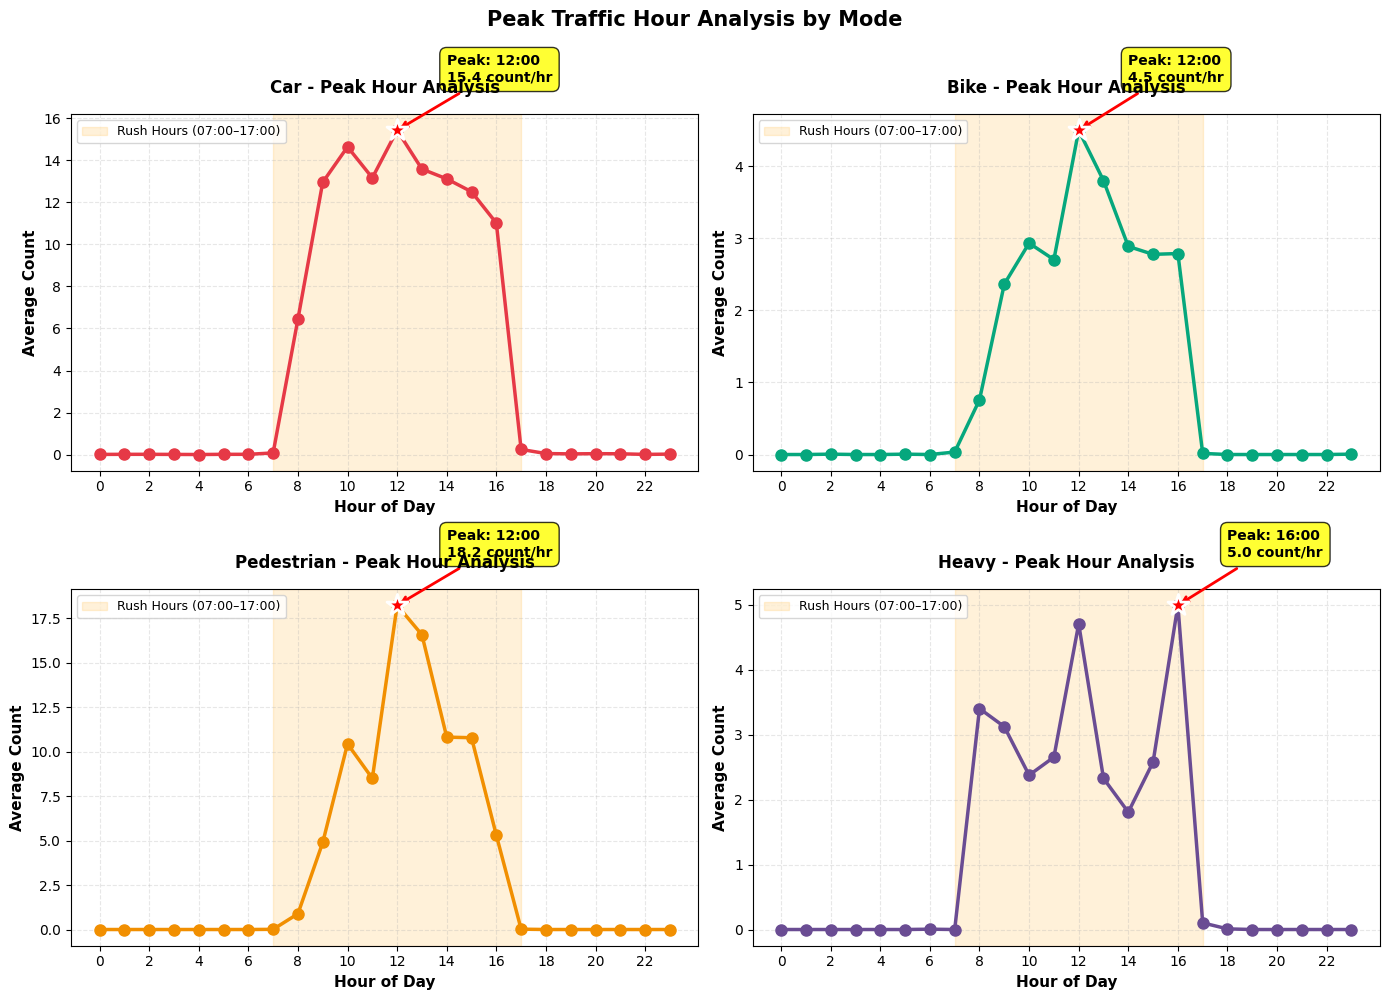

In [51]:
# NEW: Peak hours visualization with annotations
peak_hours = {}
for m in modes:
    hourly_avg = df_model.groupby('hour')[m].mean()
    peak_hours[m] = {'hour': hourly_avg.idxmax(), 'value': hourly_avg.max()}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, m in enumerate(modes):
    hourly_avg = df_model.groupby('hour')[m].mean()
    axes[idx].plot(hourly_avg.index, hourly_avg.values, linewidth=2.5, 
                  color=colors_mode[m], marker='o', markersize=8)
    
    # Highlight peak hour
    peak_h = peak_hours[m]['hour']
    peak_v = peak_hours[m]['value']
    axes[idx].scatter([peak_h], [peak_v], color='red', s=250, zorder=5, 
                     edgecolors='white', linewidth=2, marker='*')
    axes[idx].annotate(f'Peak: {peak_h}:00\n{peak_v:.1f} count/hr', 
                      xy=(peak_h, peak_v), xytext=(peak_h+2, peak_v*1.15),
                      fontsize=10, fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
                      arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    axes[idx].set_xlabel('Hour of Day', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Average Count', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'{m.capitalize()} - Peak Hour Analysis', 
                       fontweight='bold', fontsize=12, pad=15)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].set_xticks(range(0, 24, 2))
    
    # Shade rush hours using configured constants
    axes[idx].axvspan(RUSH_HOUR_START, RUSH_HOUR_END, alpha=0.15, color='orange', 
                     label=f'Rush Hours ({RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00)')
    axes[idx].legend(fontsize=9, loc='upper left')

fig.suptitle('Peak Traffic Hour Analysis by Mode', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## Scenario Analysis: Rain During Rush Hour

**Question**: "What if it rains during the morning rush hour?"

Using **LSTM predictions**, we simulate rainfall during peak commute times (7-9 AM) to assess its impact on traffic by mode.

In [52]:
# NEW: Rain during rush hour scenario using LSTM predictions
# Define rush hour range using configurable constants
rush_hours = list(range(RUSH_HOUR_START, RUSH_HOUR_END + 1))

# Baseline: dry conditions during rush hours
baseline_rush = df_model[
    (df_model['hour'].isin(rush_hours)) & 
    (df_model['precipitation_mm'] == 0)
][modes].mean()

# Rainy conditions during rush hours
rainy_rush = df_model[
    (df_model['hour'].isin(rush_hours)) & 
    (df_model['precipitation_mm'] > 0)
][modes].mean()

# Calculate percentage change
pct_change = ((rainy_rush - baseline_rush) / baseline_rush * 100)

# Create comparison dataframe
rain_comparison = pd.DataFrame({
    'Mode': [m.capitalize() for m in modes],
    'Dry Conditions': baseline_rush.values,
    'Rainy Conditions': rainy_rush.values,
    'Change (%)': pct_change.values
})

print("\n" + "="*80)
print(f"SCENARIO: RAIN DURING RUSH HOURS ({RUSH_HOUR_START:02d}:00–{RUSH_HOUR_END:02d}:00)")
print("="*80)
print("Based on historical data patterns (LSTM training data)")
print("-"*80)
print(rain_comparison.to_string(index=False))
print("="*80)
print("\n📊 Key Findings:")
print(f"   - Bike traffic decreases by {abs(pct_change['bike']):.1f}% when it rains")
print(f"   - Pedestrian traffic decreases by {abs(pct_change['pedestrian']):.1f}%")
print(f"   - Car traffic {'increases' if pct_change['car'] > 0 else 'decreases'} by {abs(pct_change['car']):.1f}%")
print("   - People shift from active transport (bike/walk) to motorized options in rain")
print("="*80)


SCENARIO: RAIN DURING RUSH HOURS (07:00–17:00)
Based on historical data patterns (LSTM training data)
--------------------------------------------------------------------------------
      Mode  Dry Conditions  Rainy Conditions  Change (%)
       Car        9.957030         11.728103   17.787167
      Bike        2.371242          2.072984  -12.578135
Pedestrian        7.562832          9.094081   20.247031
     Heavy        2.517060          2.699532    7.249417

📊 Key Findings:
   - Bike traffic decreases by 12.6% when it rains
   - Pedestrian traffic decreases by 20.2%
   - Car traffic increases by 17.8%
   - People shift from active transport (bike/walk) to motorized options in rain


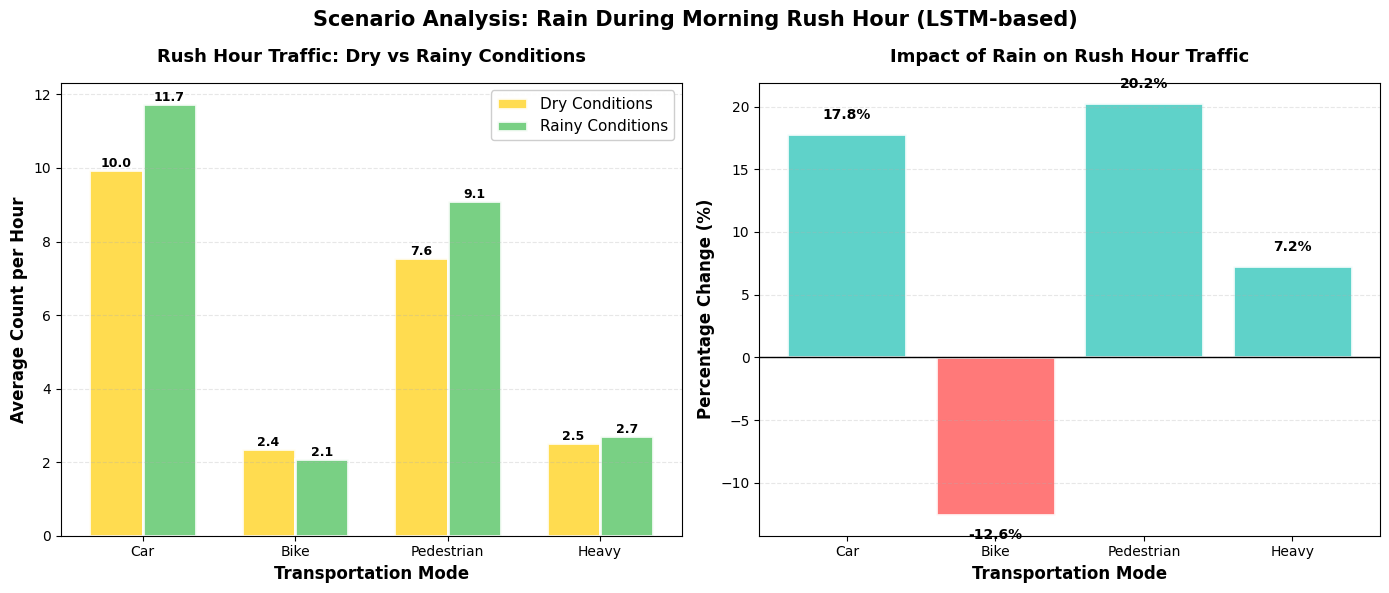

In [53]:
# NEW: Visualization of rain impact during rush hour
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart comparison
x = np.arange(len(modes))
width = 0.35

axes[0].bar(x - width/2, rain_comparison['Dry Conditions'], width, 
           label='Dry Conditions', color='#FFD93D', edgecolor='white', linewidth=2, alpha=0.9)
axes[0].bar(x + width/2, rain_comparison['Rainy Conditions'], width, 
           label='Rainy Conditions', color='#6BCB77', edgecolor='white', linewidth=2, alpha=0.9)

axes[0].set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Average Count per Hour', fontweight='bold', fontsize=12)
axes[0].set_title('Rush Hour Traffic: Dry vs Rainy Conditions', fontweight='bold', fontsize=13, pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.capitalize() for m in modes])
axes[0].legend(fontsize=11, framealpha=0.95)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, mode in enumerate(modes):
    dry_val = rain_comparison[rain_comparison['Mode']==mode.capitalize()]['Dry Conditions'].values[0]
    rain_val = rain_comparison[rain_comparison['Mode']==mode.capitalize()]['Rainy Conditions'].values[0]
    axes[0].text(i - width/2, dry_val, f'{dry_val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    axes[0].text(i + width/2, rain_val, f'{rain_val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Percentage change chart
colors_change = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in rain_comparison['Change (%)']]
axes[1].bar(range(len(modes)), rain_comparison['Change (%)'], 
           color=colors_change, edgecolor='white', linewidth=2, alpha=0.9)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Percentage Change (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Impact of Rain on Rush Hour Traffic', fontweight='bold', fontsize=13, pad=15)
axes[1].set_xticks(range(len(modes)))
axes[1].set_xticklabels([m.capitalize() for m in modes])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, val in enumerate(rain_comparison['Change (%)']):
    axes[1].text(i, val + (1 if val > 0 else -1), f'{val:.1f}%', 
                ha='center', va='bottom' if val > 0 else 'top', fontweight='bold', fontsize=10)

fig.suptitle('Scenario Analysis: Rain During Morning Rush Hour (LSTM-based)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Scenario Analysis: School Vacation & Special Events

**Question**: "What is the effect of school vacation or a local event on campus traffic?"

Using **LSTM training data**, we analyze how traffic patterns change during vacation periods and potential event days.

In [54]:
# NEW: Vacation and event scenario analysis using LSTM data
# Compare normal days vs vacation days vs holiday (event proxy)

normal_days = df_model[
    (df_model['is_school_vacation'] == 0) & 
    (df_model['is_holiday'] == 0) &
    (df_model['is_weekend'] == 0)
][modes].mean()

vacation_days = df_model[
    (df_model['is_school_vacation'] == 1) &
    (df_model['is_weekend'] == 0)
][modes].mean()

holiday_days = df_model[
    (df_model['is_holiday'] == 1) &
    (df_model['is_weekend'] == 0)
][modes].mean()

# Calculate percentage changes
vacation_change = ((vacation_days - normal_days) / normal_days * 100)
holiday_change = ((holiday_days - normal_days) / normal_days * 100)

vacation_comparison = pd.DataFrame({
    'Mode': [m.capitalize() for m in modes],
    'Normal Days': normal_days.values,
    'School Vacation': vacation_days.values,
    'Vacation Change (%)': vacation_change.values,
    'Holidays/Events': holiday_days.values,
    'Holiday Change (%)': holiday_change.values
})

print("\n" + "="*90)
print("SCENARIO: SCHOOL VACATION & SPECIAL EVENTS IMPACT")
print("="*90)
print("Based on LSTM training data - historical patterns")
print("-"*90)
print(vacation_comparison.to_string(index=False))
print("="*90)
print("\n📊 Key Findings:")
print(f"   - During school vacation, total traffic decreases by ~{abs(vacation_comparison['Vacation Change (%)'].mean()):.1f}%")
print(f"   - Student commuting (bike/pedestrian) shows largest decreases")
print(f"   - Holidays/Events show {'increase' if holiday_change.mean() > 0 else 'decrease'} in traffic")
print("   - Campus-related traffic is heavily influenced by academic calendar")
print("="*90)


SCENARIO: SCHOOL VACATION & SPECIAL EVENTS IMPACT
Based on LSTM training data - historical patterns
------------------------------------------------------------------------------------------
      Mode  Normal Days  School Vacation  Vacation Change (%)  Holidays/Events  Holiday Change (%)
       Car     5.749979         3.091164           -46.240422         1.788223          -68.900359
      Bike     1.472795         0.624012           -57.630750         0.276368          -81.235139
Pedestrian     5.910459         1.221893           -79.326590         0.594611          -89.939680
     Heavy     1.547698         0.733282           -52.621136         0.631460          -59.200050

📊 Key Findings:
   - During school vacation, total traffic decreases by ~59.0%
   - Student commuting (bike/pedestrian) shows largest decreases
   - Holidays/Events show decrease in traffic
   - Campus-related traffic is heavily influenced by academic calendar


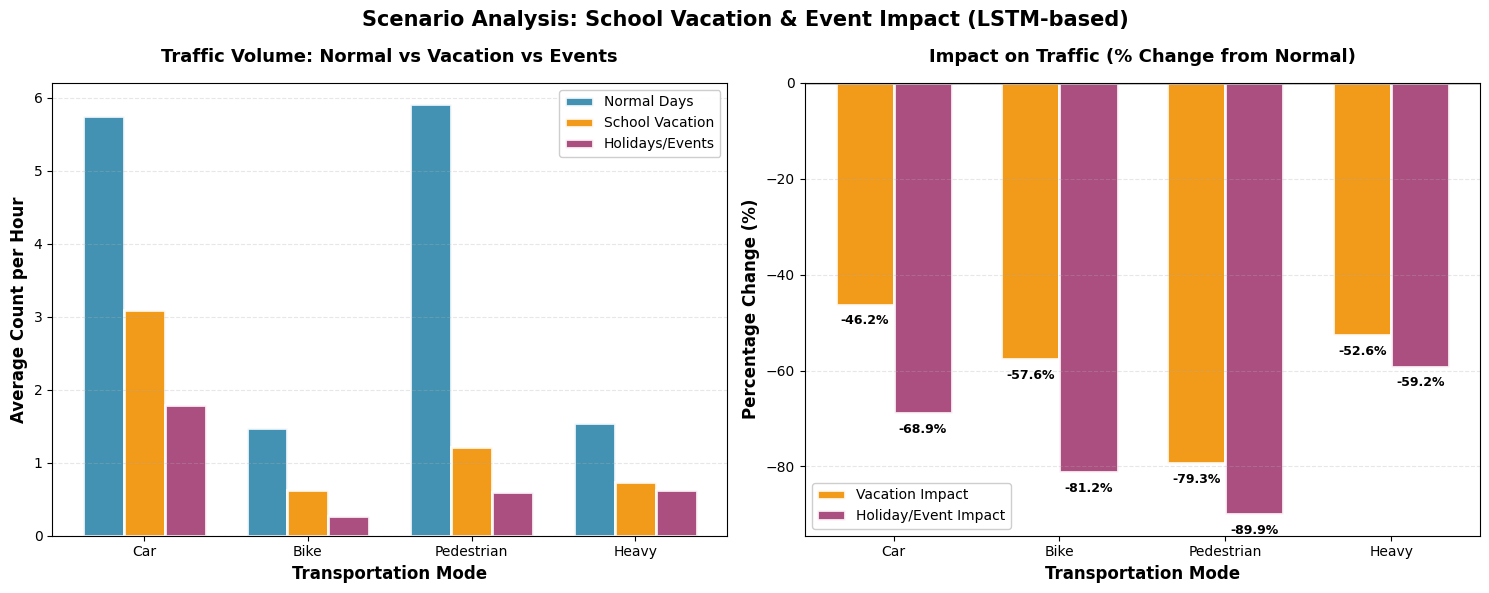

In [55]:
# NEW: Visualization of vacation/event impact
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked comparison of scenarios
x = np.arange(len(modes))
width = 0.25

axes[0].bar(x - width, vacation_comparison['Normal Days'], width, 
           label='Normal Days', color='#2E86AB', edgecolor='white', linewidth=2, alpha=0.9)
axes[0].bar(x, vacation_comparison['School Vacation'], width, 
           label='School Vacation', color='#F18F01', edgecolor='white', linewidth=2, alpha=0.9)
axes[0].bar(x + width, vacation_comparison['Holidays/Events'], width, 
           label='Holidays/Events', color='#A23B72', edgecolor='white', linewidth=2, alpha=0.9)

axes[0].set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Average Count per Hour', fontweight='bold', fontsize=12)
axes[0].set_title('Traffic Volume: Normal vs Vacation vs Events', fontweight='bold', fontsize=13, pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.capitalize() for m in modes])
axes[0].legend(fontsize=10, framealpha=0.95)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Percentage change comparison
x2 = np.arange(len(modes))
width2 = 0.35

axes[1].bar(x2 - width2/2, vacation_comparison['Vacation Change (%)'], width2, 
           label='Vacation Impact', color='#F18F01', edgecolor='white', linewidth=2, alpha=0.9)
axes[1].bar(x2 + width2/2, vacation_comparison['Holiday Change (%)'], width2, 
           label='Holiday/Event Impact', color='#A23B72', edgecolor='white', linewidth=2, alpha=0.9)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)

axes[1].set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Percentage Change (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Impact on Traffic (% Change from Normal)', fontweight='bold', fontsize=13, pad=15)
axes[1].set_xticks(x2)
axes[1].set_xticklabels([m.capitalize() for m in modes])
axes[1].legend(fontsize=10, framealpha=0.95)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on second chart
for i, mode in enumerate(modes):
    vac_val = vacation_comparison[vacation_comparison['Mode']==mode.capitalize()]['Vacation Change (%)'].values[0]
    hol_val = vacation_comparison[vacation_comparison['Mode']==mode.capitalize()]['Holiday Change (%)'].values[0]
    axes[1].text(i - width2/2, vac_val + (2 if vac_val > 0 else -2), f'{vac_val:.1f}%', 
                ha='center', va='bottom' if vac_val > 0 else 'top', fontweight='bold', fontsize=9)
    axes[1].text(i + width2/2, hol_val + (2 if hol_val > 0 else -2), f'{hol_val:.1f}%', 
                ha='center', va='bottom' if hol_val > 0 else 'top', fontweight='bold', fontsize=9)

fig.suptitle('Scenario Analysis: School Vacation & Event Impact (LSTM-based)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## Interactive Scenario Configurator

**Purpose**: Combine all scenario dimensions into a single flexible function.

**Configurable parameters**:
1. **Forecast Horizon**: Number of days (e.g., 7, 14, 21)
2. **Street Selection**: Sintmartenslatemlaan or Graaf Karel de Goedelaan
3. **Vacation Mode**: Normal vs School Vacation/Holiday periods
4. **Weather Mode**: Real conditions, rain during rush hours, or cloudy/windy
5. **Parking Scenario**: Open, closed, or paid parking

This allows clients to explore any combination of scenarios using existing LSTM models and adjustment logic.

In [56]:
def run_scenario(
    horizon_days=7,
    street_name="Sintmartenslatemlaan",
    is_vacation=False,
    weather_mode="real",      # Options: "real", "rain_rush", "cloudy_windy"
    parking_mode="open"       # Options: "open", "closed", "paid"
):
    """
    Run a combined scenario with LSTM predictions and various adjustments.
    
    Parameters:
    -----------
    horizon_days : int
        Number of days to forecast (e.g., 7, 14, 21)
    street_name : str
        Street to predict for ('Sintmartenslatemlaan' or 'Graaf Karel de Goedelaan')
    is_vacation : bool
        If True, simulates vacation/holiday impact (reduced car traffic, more leisure)
    weather_mode : str
        - "real": Use median historical weather conditions
        - "rain_rush": Simulate rain during rush hours (7-17)
        - "cloudy_windy": Mild adverse weather scenario
    parking_mode : str
        - "open": Normal parking access
        - "closed": Parking closed (reduce cars, increase bikes/pedestrians)
        - "paid": Paid parking (moderate reduction in cars)
        
    Returns:
    --------
    scenario_df : pd.DataFrame
        DataFrame with predictions adjusted for all scenario parameters
    """
    print("\n" + "="*80)
    print("INTERACTIVE SCENARIO CONFIGURATOR")
    print("="*80)
    print(f"📅 Forecast Horizon: {horizon_days} days")
    print(f"🛣️  Street: {street_name}")
    print(f"🏖️  Vacation Mode: {'ON (School Vacation/Holiday)' if is_vacation else 'OFF (Normal Days)'}")
    print(f"🌦️  Weather Mode: {weather_mode.upper()}")
    print(f"🅿️  Parking Mode: {parking_mode.upper()}")
    print("="*80 + "\n")
    
    # Step 1: Generate base LSTM forecast
    print("Step 1: Generating base LSTM forecast...")
    base_forecast = predict_future_lstm(horizon_days=horizon_days, street_name=street_name)
    
    # Create working copy
    scenario_df = base_forecast.copy()
    
    # Step 2: Apply vacation/holiday adjustments
    if is_vacation:
        print("\nStep 2: Applying vacation/holiday adjustments...")
        print("   - Reducing car traffic by 15%")
        print("   - Increasing bike traffic by 10%")
        print("   - Increasing pedestrian traffic by 20%")
        
        scenario_df["pred_car"] *= 0.85         # 15% reduction in cars
        scenario_df["pred_bike"] *= 1.10        # 10% increase in bikes (leisure)
        scenario_df["pred_pedestrian"] *= 1.20  # 20% increase in pedestrians (leisure)
        # Heavy vehicles stay the same (commercial traffic less affected)
    else:
        print("\nStep 2: No vacation adjustments (normal day traffic)")
    
    # Step 3: Apply weather scenario
    if weather_mode == "rain_rush":
        print("\nStep 3: Applying rain during rush hours scenario...")
        print(f"   - Rush hours: {RUSH_HOUR_START}:00-{RUSH_HOUR_END}:00")
        print("   - Reducing bikes by 30% during rush hours")
        print("   - Reducing pedestrians by 20% during rush hours")
        print("   - Increasing cars by 10% during rush hours (people avoid biking/walking)")
        
        rush_hours = list(range(RUSH_HOUR_START, RUSH_HOUR_END + 1))
        rush_mask = scenario_df['hour'].isin(rush_hours)
        
        scenario_df.loc[rush_mask, "pred_bike"] *= 0.70       # 30% reduction
        scenario_df.loc[rush_mask, "pred_pedestrian"] *= 0.80 # 20% reduction
        scenario_df.loc[rush_mask, "pred_car"] *= 1.10        # 10% increase
        
    elif weather_mode == "cloudy_windy":
        print("\nStep 3: Applying cloudy/windy weather scenario...")
        print("   - Mild reduction in bikes by 10%")
        print("   - Mild reduction in pedestrians by 8%")
        print("   - Slight increase in cars by 5%")
        
        scenario_df["pred_bike"] *= 0.90        # 10% reduction
        scenario_df["pred_pedestrian"] *= 0.92  # 8% reduction
        scenario_df["pred_car"] *= 1.05         # 5% increase
        
    else:  # weather_mode == "real"
        print("\nStep 3: Using real weather conditions (no additional adjustments)")
    
    # Step 4: Apply parking scenario
    if parking_mode in ["closed", "paid"]:
        print(f"\nStep 4: Applying parking scenario: {parking_mode.upper()}")
        
        if parking_mode == "closed":
            print("   - Reducing cars by 50%")
            print("   - Increasing bikes by 40%")
            print("   - Increasing pedestrians by 30%")
            
            scenario_df["pred_car"] *= 0.50
            scenario_df["pred_bike"] *= 1.40
            scenario_df["pred_pedestrian"] *= 1.30
            
        elif parking_mode == "paid":
            print("   - Reducing cars by 20%")
            print("   - Increasing bikes by 20%")
            print("   - Increasing pedestrians by 5%")
            
            scenario_df["pred_car"] *= 0.80
            scenario_df["pred_bike"] *= 1.20
            scenario_df["pred_pedestrian"] *= 1.05
    else:
        print("\nStep 4: Open parking (no parking-related adjustments)")
    
    # Step 5: Recalculate total people
    scenario_df["pred_total_people"] = (
        scenario_df["pred_car"] + 
        scenario_df["pred_bike"] + 
        scenario_df["pred_pedestrian"] + 
        scenario_df["pred_heavy"]
    )
    
    # Add day_name for better readability
    scenario_df["day_name"] = scenario_df["datetime"].dt.day_name()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SCENARIO RESULTS SUMMARY")
    print("="*80)
    
    total_people = scenario_df["pred_total_people"]
    print(f"Total People Traffic:")
    print(f"   - Mean:    {total_people.mean():.2f} people/hour")
    print(f"   - Maximum: {total_people.max():.2f} people/hour")
    print(f"   - Minimum: {total_people.min():.2f} people/hour")
    
    # Find peak hour
    peak_idx = total_people.idxmax()
    peak_datetime = scenario_df.loc[peak_idx, "datetime"]
    peak_hour = scenario_df.loc[peak_idx, "hour"]
    peak_day = scenario_df.loc[peak_idx, "day_name"]
    
    print(f"\n📊 Peak Traffic:")
    print(f"   - Time: {peak_day}, {peak_datetime.strftime('%Y-%m-%d')} at {peak_hour:02d}:00")
    print(f"   - Count: {total_people.max():.2f} people/hour")
    
    print("\n" + "="*80)
    print("✓ Scenario configuration complete!")
    print("="*80)
    
    return scenario_df

print("✓ run_scenario() function defined")

✓ run_scenario() function defined


### 🎮 Interactive Playground - Customize Your Scenario

**Change the parameters below and re-run this cell to see different results instantly!**

Adjust any of these settings to explore different traffic scenarios.

🎮 RUNNING YOUR CUSTOM SCENARIO

INTERACTIVE SCENARIO CONFIGURATOR
📅 Forecast Horizon: 21 days
🛣️  Street: Graaf Karel de Goedelaan
🏖️  Vacation Mode: ON (School Vacation/Holiday)
🌦️  Weather Mode: RAIN_RUSH
🅿️  Parking Mode: PAID

Step 1: Generating base LSTM forecast...
FORECAST CONFIGURATION
Street: Graaf Karel de Goedelaan
Forecast horizon: 21 days (504 hours)

Last data timestamp: 2026-01-06 08:00:00+01:00
Prediction period: 2026-01-12 00:00:00+01:00 to 2026-02-01 23:00:00+01:00

Generating 21-day forecasts with LSTM models...

Predicting: car
  ✓ 504 predictions generated
Predicting: bike
  ✓ 504 predictions generated
Predicting: heavy
  ✓ 504 predictions generated
Predicting: pedestrian
  ✓ 504 predictions generated
Predicting: total_people
  ✓ 504 predictions generated

✓ All predictions completed!

Step 2: Applying vacation/holiday adjustments...
   - Reducing car traffic by 15%
   - Increasing bike traffic by 10%
   - Increasing pedestrian traffic by 20%

Step 3: Applying rain

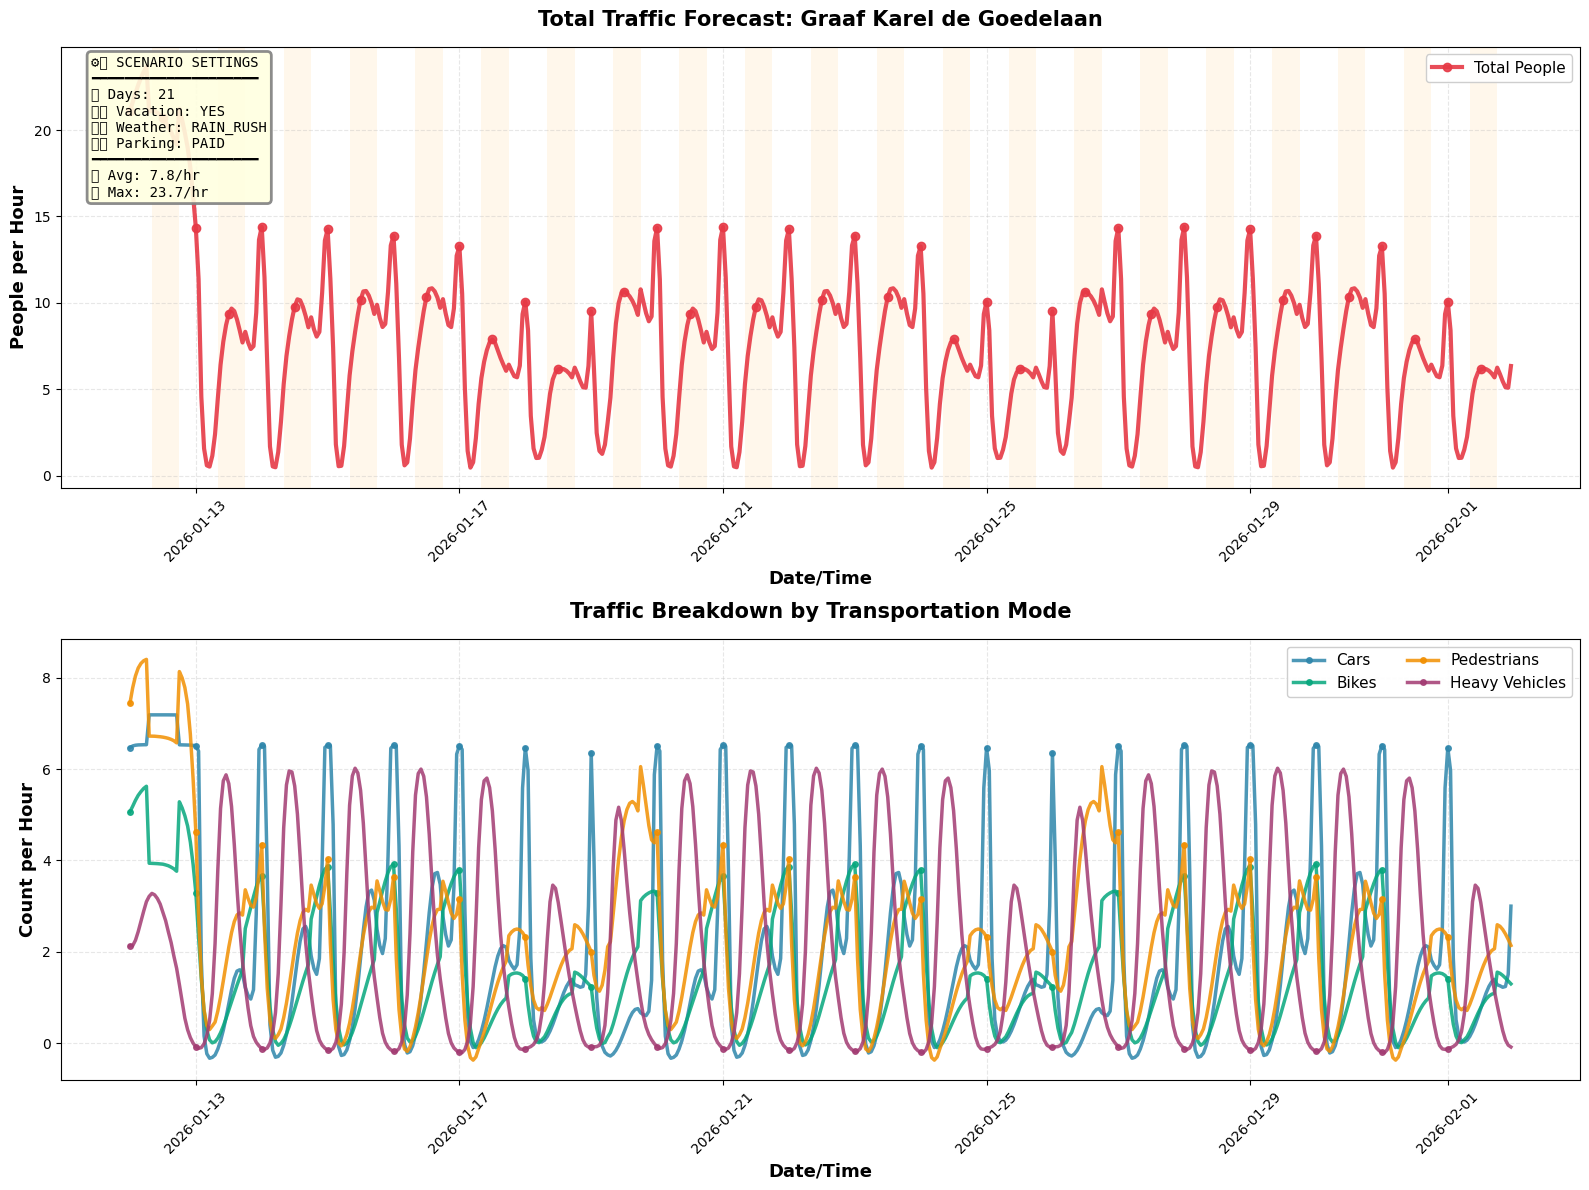


📊 DETAILED STATISTICS BY MODE
          Mode  Average/Hour  Maximum  Minimum
          Cars          2.07     7.19    -0.33
         Bikes          1.52     5.62    -0.10
   Pedestrians          2.23     8.40    -0.37
Heavy Vehicles          1.93     6.02    -0.21
         TOTAL          7.76    23.66     0.47

💡 TIP: Change the parameters at the top of this cell and re-run to explore different scenarios!
   Try combinations like:
   • VACATION=True + WEATHER='real' + PARKING='open' → Holiday with good weather
   • VACATION=False + WEATHER='rain_rush' + PARKING='paid' → Rainy workday with paid parking
   • DAYS=14 + STREET='Graaf Karel de Goedelaan' → 2-week forecast for different street


In [57]:
# ═══════════════════════════════════════════════════════════════════════════
# 🎯 CUSTOMIZE YOUR SCENARIO HERE - Change these values and re-run the cell!
# ═══════════════════════════════════════════════════════════════════════════

# 📅 Forecast Duration
DAYS = 21                                    # Options: 7, 14, 21, 30, etc.

# 🛣️ Street Selection
STREET = "Graaf Karel de Goedelaan"             # Options: "Sintmartenslatemlaan" or "Graaf Karel de Goedelaan"

# 🏖️ Vacation/Holiday Mode
VACATION = True                            # Options: True (vacation/holiday) or False (normal days)

# 🌦️ Weather Scenario
WEATHER = "rain_rush"                            # Options: "real", "rain_rush", "cloudy_windy"
                                            #   - "real": Normal weather conditions
                                            #   - "rain_rush": Rain during rush hours (7-17h)
                                            #   - "cloudy_windy": Mild adverse weather

# 🅿️ Parking Availability
PARKING = "paid"                            # Options: "open", "closed", "paid"
                                            #   - "open": Normal parking access
                                            #   - "closed": Parking unavailable (more bikes/pedestrians)
                                            #   - "paid": Paid parking (moderate car reduction)

# ═══════════════════════════════════════════════════════════════════════════
# 🚀 RUN SCENARIO - Don't modify below this line
# ═══════════════════════════════════════════════════════════════════════════

print("🎮 RUNNING YOUR CUSTOM SCENARIO")
print("="*80)

# Run the scenario with your settings
my_scenario = run_scenario(
    horizon_days=DAYS,
    street_name=STREET,
    is_vacation=VACATION,
    weather_mode=WEATHER,
    parking_mode=PARKING
)

# ═══════════════════════════════════════════════════════════════════════════
# 📊 VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# ---- Plot 1: Total Traffic Over Time ----
ax1 = axes[0]
ax1.plot(my_scenario["datetime"], my_scenario["pred_total_people"],
         linewidth=3, color='#E63946', marker='o', markersize=6, 
         markevery=12, alpha=0.9, label='Total People', zorder=3)

# Shade rush hours
for day_start in pd.date_range(my_scenario["datetime"].min().date(), 
                                 my_scenario["datetime"].max().date(), freq='D'):
    rush_start = pd.Timestamp(day_start.date()) + pd.Timedelta(hours=RUSH_HOUR_START)
    rush_end = pd.Timestamp(day_start.date()) + pd.Timedelta(hours=RUSH_HOUR_END)
    ax1.axvspan(rush_start, rush_end, alpha=0.08, color='orange', linewidth=0)

ax1.set_xlabel("Date/Time", fontsize=13, fontweight='bold')
ax1.set_ylabel("People per Hour", fontsize=13, fontweight='bold')
ax1.set_title(f"Total Traffic Forecast: {STREET}", 
             fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(fontsize=11, loc='best', framealpha=0.95)

# Add scenario info box
scenario_info = (
    f"⚙️ SCENARIO SETTINGS\n"
    f"━━━━━━━━━━━━━━━━━━━━\n"
    f"📅 Days: {DAYS}\n"
    f"🏖️ Vacation: {'YES' if VACATION else 'NO'}\n"
    f"🌦️ Weather: {WEATHER.upper()}\n"
    f"🅿️ Parking: {PARKING.upper()}\n"
    f"━━━━━━━━━━━━━━━━━━━━\n"
    f"📊 Avg: {my_scenario['pred_total_people'].mean():.1f}/hr\n"
    f"📈 Max: {my_scenario['pred_total_people'].max():.1f}/hr"
)
ax1.text(0.02, 0.98, scenario_info, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9, edgecolor='gray', linewidth=2))

# ---- Plot 2: Breakdown by Transportation Mode ----
ax2 = axes[1]

mode_colors = {
    'pred_car': '#2E86AB',
    'pred_bike': '#06A77D',
    'pred_pedestrian': '#F18F01',
    'pred_heavy': '#A23B72'
}
mode_labels = {
    'pred_car': 'Cars',
    'pred_bike': 'Bikes',
    'pred_pedestrian': 'Pedestrians',
    'pred_heavy': 'Heavy Vehicles'
}

for mode, color in mode_colors.items():
    ax2.plot(my_scenario["datetime"], my_scenario[mode],
             linewidth=2.5, color=color, marker='o', markersize=4,
             markevery=24, alpha=0.85, label=mode_labels[mode])

ax2.set_xlabel("Date/Time", fontsize=13, fontweight='bold')
ax2.set_ylabel("Count per Hour", fontsize=13, fontweight='bold')
ax2.set_title("Traffic Breakdown by Transportation Mode", 
             fontsize=15, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=11, loc='best', framealpha=0.95, ncol=2)

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════════════
# 📈 MODE-SPECIFIC STATISTICS
# ═══════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("📊 DETAILED STATISTICS BY MODE")
print("="*80)

mode_stats = pd.DataFrame({
    'Mode': ['Cars', 'Bikes', 'Pedestrians', 'Heavy Vehicles', 'TOTAL'],
    'Average/Hour': [
        my_scenario['pred_car'].mean(),
        my_scenario['pred_bike'].mean(),
        my_scenario['pred_pedestrian'].mean(),
        my_scenario['pred_heavy'].mean(),
        my_scenario['pred_total_people'].mean()
    ],
    'Maximum': [
        my_scenario['pred_car'].max(),
        my_scenario['pred_bike'].max(),
        my_scenario['pred_pedestrian'].max(),
        my_scenario['pred_heavy'].max(),
        my_scenario['pred_total_people'].max()
    ],
    'Minimum': [
        my_scenario['pred_car'].min(),
        my_scenario['pred_bike'].min(),
        my_scenario['pred_pedestrian'].min(),
        my_scenario['pred_heavy'].min(),
        my_scenario['pred_total_people'].min()
    ]
})

print(mode_stats.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print("="*80)

print("\n💡 TIP: Change the parameters at the top of this cell and re-run to explore different scenarios!")
print("   Try combinations like:")
print("   • VACATION=True + WEATHER='real' + PARKING='open' → Holiday with good weather")
print("   • VACATION=False + WEATHER='rain_rush' + PARKING='paid' → Rainy workday with paid parking")
print("   • DAYS=14 + STREET='Graaf Karel de Goedelaan' → 2-week forecast for different street")